In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import joblib

from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV,
    RandomizedSearchCV, learning_curve, validation_curve
)
from sklearn.metrics import (
    make_scorer, mean_squared_error, classification_report, accuracy_score, roc_auc_score,
    roc_curve, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score,
    matthews_corrcoef, average_precision_score, auc, precision_recall_curve
)
from sklearn.preprocessing import (
    OrdinalEncoder, OneHotEncoder, KBinsDiscretizer, Binarizer, StandardScaler,
    MinMaxScaler, RobustScaler, LabelEncoder, FunctionTransformer, PowerTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import (
    VarianceThreshold, SelectFromModel, SelectKBest, f_classif, mutual_info_classif
)
from sklearn.datasets import make_classification, load_iris
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import set_config

# Opcjonalnie: ustawienie konfiguracji scikit-learn
set_config(display="diagram")  # Wyświetlanie diagramów potoków

# Opcjonalnie: wyłączenie ostrzeżeń
import warnings
warnings.filterwarnings("ignore")

# Konfiguracja wyjścia dla transformacji
set_config(transform_output='pandas')

# Setting display options for pandas
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import markdown
from IPython.display import display, Markdown

# I. Wprowadzenie

### 1. Cel projektu


> Stworzenie modelu, który przewiduje, czy klient banku otrzyma kredyt hipoteczny.

# II. Wczytanie i wstępne przetwarzanie danych

### 1. Wczytanie danych źródłówych

> Dane do budowy modelu uczenia maszynowego zostały wygenerowne syntetycznie za pomocą kodu python. 

> Są to dane fikcyjne wygenerowane w celu demonstracyjnym.

> Wygenerowane dane zawierają wiele zmiennych , które zostana wykorzystane do budowy modelu klasyfikacyjnego, które celem jest ustalenie czy klient banku w oparciu o wybrane zmienne/cechy otrzyma kredyt hipoteczny , czy nie otrzyma.

> Wygenerowane dane zostały zapisane do pliku excel.

In [5]:

# ====================================================================
# 1. Wczytanie i wstępne przetwarzanie danych
# ====================================================================

## 1.1. Wczytanie danych z pliku Excel
df = pd.read_excel('synthetic_data.xlsx')



### 2. Podstawowe informacje o danych

In [19]:
display(Markdown("**Wgląd w strukturę danych:**"))

def analiza_dataframe(df):
    # Liczba kolumn
    liczba_kolumn = len(df.columns)
    
    # Liczba wierszy
    liczba_wierszy = len(df)
    
    # Liczba kolumn numerycznych, tekstowych, dat i boolowskich
    liczba_kolumn_numerycznych = len(df.select_dtypes(include='number').columns)
    liczba_kolumn_textowych = len(df.select_dtypes(include='object').columns)
    liczba_kolumn_dat = len(df.select_dtypes(include='datetime').columns)
    liczba_kolumn_bool = len(df.select_dtypes(include='bool').columns)

    # Tworzenie DataFrame z wynikami
    wyniki = pd.DataFrame({
        'Liczba kolumn': [liczba_kolumn],
        'Liczba wierszy': [liczba_wierszy],
        'Liczba kolumn numerycznych': [liczba_kolumn_numerycznych],
        'Liczba kolumn tekstowych': [liczba_kolumn_textowych],
        'Liczba kolumn dat': [liczba_kolumn_dat],
        'Liczba kolumn bool': [liczba_kolumn_bool]
    })
    wyniki = wyniki.sort_values(by='Liczba kolumn numerycznych', ascending=False).reset_index(drop=True)
    return wyniki




import pandas as pd

def informacje_o_dataframe(df, dodatkowe_kolumny_numeryczne=None):
    informacje = []

    if dodatkowe_kolumny_numeryczne is None:
        dodatkowe_kolumny_numeryczne = []

    for kolumna in df.columns:
        typ_kolumny = df[kolumna].dtype
        unikalne_wartosci = df[kolumna].nunique()
        puste_wartosci = df[kolumna].isnull().sum()
        niepuste_wartosci = df[kolumna].count()

        if typ_kolumny == 'object' or kolumna in dodatkowe_kolumny_numeryczne:
            unikalne_wartosci_lista = df[kolumna].unique()
        else:
            unikalne_wartosci_lista = " "

        informacje.append([kolumna, typ_kolumny, unikalne_wartosci, puste_wartosci, niepuste_wartosci, unikalne_wartosci_lista])

    informacje_df = pd.DataFrame(informacje, columns=['Nazwa kolumny', 'Typ kolumny', 'Liczba unikalnych wartości', 'Liczba wartości pustych', 'Liczba wartości niepustych', 'Wartości unikatowe dla zmiennych kategorialnych'])
    informacje_df = informacje_df.sort_values(by='Typ kolumny').reset_index(drop=True)
    return informacje_df
    

# Aby wyświetlić unikalne wartości dla kolumn tekstowych oraz 'ilość_dzieci', 'ilość_kredytów' i 'kredyt':
informacje_df = informacje_o_dataframe(df, dodatkowe_kolumny_numeryczne=['ilość_dzieci', 'ilość_kredytów', 'kredyt'])


display(analiza_dataframe(df))
print()
display(Markdown("""**Wygenerowane dane, są zbiorem, 
                 który będzie wykorzystany do modelowania predykcyjnego, 
                  w kontekście oceny ryzyka kredytowego. 
                 Poniżej znajduje się szczegółowy opis poszczególnych kolumn:**
"""))

display(informacje_df)





display(Markdown("**Przykładowe dane - 8 losowych wierszy:**"))
display(df.sample(8).T)


**Wgląd w strukturę danych:**

Liczba kolumn  Liczba wierszy  Liczba kolumn numerycznych  \
0             25            1003                          16   

   Liczba kolumn tekstowych  Liczba kolumn dat  Liczba kolumn bool  
0                         9                  0                   0

**Wygenerowane dane, są zbiorem, 
                 który będzie wykorzystany do modelowania predykcyjnego, 
                  w kontekście oceny ryzyka kredytowego. 
                 Poniżej znajduje się szczegółowy opis poszczególnych kolumn:**


Nazwa kolumny Typ kolumny  Liczba unikalnych wartości  \
0                          wiek       int64                          52   
1   dochody nie ewidencjonowane       int64                         915   
2                  ilość_dzieci       int64                           5   
3                ilość_kredytów       int64                           3   
4                        kredyt       int64                           2   
5                  oszczędności     float64                         979   
6                        dochód     float64                         983   
7           dochody z zagranicy     float64                         955   
8                    zadłużenie     float64                         974   
9               koszty rachunku     float64                          62   
10      liczba wizyt w oddziale     float64                          57   
11           dodatkowy_przychód     float64                         999   
12                   inwestycje     float64                         999   
13                kwota_kredytu     float64                         999   
14        wartość_nieruchomości     float64                         995   
15            koszty_utrzymania     float64                         998   
16          czy_karta_kredytowa      object                           2   
17     czy_korzysta_z_aplikacji      object                           2   
18                wykształcenie      object                           4   
19        sytuacja_mieszkaniowa      object                           3   
20          forma_wynagrodzenia      object                           3   
21               źródło_dochodu      object                          10   
22           typ_zabezpieczenia      object                           3   
23           czy_aktywny_online      object                           2   
24            czy_ubezpieczenie      object                           2   

    Liczba wartości pustych  Liczba wartości niepustych  \
0                         0                        1003   
1                         0                        1003   
2                         0                        1003   
3                         0                        1003   
4                         0                        1003   
5                         1                        1002   
6                         0                        1003   
7                         1                        1002   
8                         0                        1003   
9                         1                        1002   
10                        1                        1002   
11                        1                        1002   
12                        1                        1002   
13                        1                        1002   
14                        1                        1002   
15                        1                        1002   
16                        1                        1002   
17                        0                        1003   
18                        2                        1001   
19                        0                        1003   
20                        0                        1003   
21                        2                        1001   
22                        0                        1003   
23                        0                        1003   
24                        2                        1001   

                                                                                                                                                                  Wartości unikatowe dla zmiennych kategorialnych  
0                                                                                                                                                                                                                  
1                                                                                                           

**Przykładowe dane - 8 losowych wierszy:**

884                     663  \
wiek                                             46                      34   
dochód                                      4947.19                 3784.36   
oszczędności                                    0.0                10516.52   
zadłużenie                                  9679.61                11561.89   
ilość_kredytów                                    1                       0   
ilość_dzieci                                      0                       0   
wartość_nieruchomości                     318029.49                 50000.0   
kwota_kredytu                              30467.11                40135.07   
inwestycje                                 49420.08                60619.46   
dodatkowy_przychód                         20016.29                17739.88   
koszty_utrzymania                          22552.37                16216.45   
czy_karta_kredytowa                             tak                     nie   
czy_ubezpieczenie                               tak                     tak   
koszty rachunku                               99.98                  100.02   
liczba wizyt w oddziale                       50.07                   50.14   
dochody z zagranicy                          1119.0                 11619.0   
dochody nie ewidencjonowane                    1475                    2200   
wykształcenie                               średnie                zawodowe   
sytuacja_mieszkaniowa        mieszkanie z rodzicami  mieszkanie z rodzicami   
forma_wynagrodzenia                    za wykonanie              miesięczne   
źródło_dochodu                Wynagrodzenie etatowe               Emerytura   
typ_zabezpieczenia                gwarancja bankowa              poręczenie   
czy_aktywny_online                              Tak                     Nie   
czy_korzysta_z_aplikacji                        Nie                     Nie   
kredyt                                            0                       0   

                                      766                     909  \
wiek                                   39                      61   
dochód                            9341.89                 5285.89   
oszczędności                     19663.87                32571.49   
zadłużenie                        5123.17                 6316.15   
ilość_kredytów                          0                       0   
ilość_dzieci                            1                       0   
wartość_nieruchomości           513558.67               210943.12   
kwota_kredytu                    46076.47                61321.53   
inwestycje                       21074.95                87597.57   
dodatkowy_przychód               20044.39                50365.46   
koszty_utrzymania                 5643.36                 1814.07   
czy_karta_kredytowa                   tak                     tak   
czy_ubezpieczenie                     tak                     nie   
koszty rachunku                     99.88                   99.97   
liczba wizyt w oddziale             50.23                   49.79   
dochody z zagranicy                 710.0                  5083.0   
dochody nie ewidencjonowane          2852                     411   
wykształcenie                     średnie              podstawowe   
sytuacja_mieszkaniowa              własne  mieszkanie z rodzicami   
forma_wynagrodzenia          za wykonanie            za wykonanie   
źródło_dochodu                      Renta               Emerytura   
typ_zabezpieczenia               hipoteka       gwarancja bankowa   
czy_aktywny_online                    Tak                     Nie   
czy_korzysta_z_aplikacji              Nie                     Nie   
kredyt                                  1                       1   

                                                             737  \
wiek                                                          49   
dochód                                                   2864.

In [22]:

# Wydzielenie X (zmienne objaśniające) i y (zmienna docelowa)
X = df.drop('kredyt', axis=1)
y = df['kredyt']

print()

# Identyfikacja zmiennych liczbowych
numeric_variables = X.select_dtypes(include=['int64', 'float64'])
numeric_variable_names = numeric_variables.columns.tolist()

# Identyfikacja zmiennych tekstowych
non_numeric_variables = X.select_dtypes(exclude=['int64', 'float64'])
non_numeric_variable_names = non_numeric_variables.columns.tolist()

# Tworzenie DataFrame z nazwami zmiennych liczbowych i tekstowych
variables_type_info = {
    'Zmienne liczbowe': numeric_variable_names,
    'Zmienne tekstowe': non_numeric_variable_names
}
variables_type_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in variables_type_info.items()]))
variables_type_df = variables_type_df.fillna('') 
print()
display(Markdown('**Podział zmiennych/cech wg ich rodzaju:**'))
display(Markdown('**Nazwy zmiennych liczbowych i tekstowych:**'))
display(variables_type_df)


statistics = df.describe().transpose()
display(Markdown('**Statystyki dla wszystkich cech zmiennych numerycznych:**'))
display(statistics)

# Wyliczanie statystyk dla zmiennych tekstowych
text_variable_stats = non_numeric_variables.describe().transpose()

display(Markdown('**Statystyki dla zmiennych tekstowych:**'))
display(text_variable_stats)
print()


**Podział zmiennych/cech wg ich rodzaju:**

**Nazwy zmiennych liczbowych i tekstowych:**

Zmienne liczbowe          Zmienne tekstowe
0                          wiek       czy_karta_kredytowa
1                        dochód         czy_ubezpieczenie
2                  oszczędności             wykształcenie
3                    zadłużenie     sytuacja_mieszkaniowa
4                ilość_kredytów       forma_wynagrodzenia
5                  ilość_dzieci            źródło_dochodu
6         wartość_nieruchomości        typ_zabezpieczenia
7                 kwota_kredytu        czy_aktywny_online
8                    inwestycje  czy_korzysta_z_aplikacji
9            dodatkowy_przychód                          
10            koszty_utrzymania                          
11              koszty rachunku                          
12      liczba wizyt w oddziale                          
13          dochody z zagranicy                          
14  dochody nie ewidencjonowane

**Statystyki dla wszystkich cech zmiennych numerycznych:**

count           mean            std       min  \
wiek                         1003.0      39.689930       9.701975     18.00   
dochód                       1003.0    5161.768574    1948.846383   1000.00   
oszczędności                 1002.0   20134.858363    9647.506070      0.00   
zadłużenie                   1003.0    9944.368126    5057.192748      0.00   
ilość_kredytów               1003.0       0.508475       0.531144      0.00   
ilość_dzieci                 1003.0       0.916251       0.823171      0.00   
wartość_nieruchomości        1002.0  297336.029601  102086.284994  50000.00   
kwota_kredytu                1002.0   53338.115259   46372.642332   5002.64   
inwestycje                   1002.0   32034.764192   28930.993099   2007.23   
dodatkowy_przychód           1002.0   10671.875309   10251.354979    501.58   
koszty_utrzymania            1002.0   16066.356238   15335.171439   1018.07   
koszty rachunku              1002.0      99.999960       0.100700     99.66   
liczba wizyt w oddziale      1002.0      50.000768       0.097684     49.72   
dochody z zagranicy          1002.0    5098.725549    4878.981433      1.00   
dochody nie ewidencjonowane  1003.0    3011.296112    2921.332462      3.00   
kredyt                       1003.0       0.480558       0.499871      0.00   

                                     25%         50%          75%        max  
wiek                             33.0000      40.000      46.0000      78.00  
dochód                         3788.6700    5128.950    6460.2700   11386.22  
oszczędności                  13510.8475   20003.675   26573.1500   59262.38  
zadłużenie                     6309.6450   10003.410   13342.3700   26215.46  
ilość_kredytów                    0.0000       0.000       1.0000       2.00  
ilość_dzieci                      0.0000       1.000       1.0000       4.00  
wartość_nieruchomości        224959.8800  294525.365  369809.4800  652905.52  
kwota_kredytu                 20467.4225   39781.045   71533.3675  334186.55  
inwestycje                    10713.3575   23054.615   44472.8500  230340.08  
dodatkowy_przychód             3446.6250    7345.340   14825.0575   80761.78  
koszty_utrzymania              5173.1275   11010.245   22132.2900  100663.36  
koszty rachunku                  99.9400     100.000     100.0600     100.34  
liczba wizyt w oddziale          49.9300      50.000      50.0700      50.33  
dochody z zagranicy            1617.5000    3761.500    6943.7500   35348.00  
dochody nie ewidencjonowane     933.0000    2121.000    4067.0000   20556.00  
kredyt                            0.0000       0.000       1.0000       1.00

**Statystyki dla zmiennych tekstowych:**

count unique                                  top  \
czy_karta_kredytowa       1002      2                                  tak   
czy_ubezpieczenie         1001      2                                  tak   
wykształcenie             1001      4                             zawodowe   
sytuacja_mieszkaniowa     1003      3                              wynajem   
forma_wynagrodzenia       1003      3                         za wykonanie   
źródło_dochodu            1001     10  Dochody z działalności gospodarczej   
typ_zabezpieczenia        1003      3                             hipoteka   
czy_aktywny_online        1003      2                                  Tak   
czy_korzysta_z_aplikacji  1003      2                                  Nie   

                         freq  
czy_karta_kredytowa       532  
czy_ubezpieczenie         512  
wykształcenie             266  
sytuacja_mieszkaniowa     346  
forma_wynagrodzenia       355  
źródło_dochodu            180  
typ_zabezpieczenia        344  
czy_aktywny_online        505  
czy_korzysta_z_aplikacji  517

### 2.1. Ocena rozkładów zmiennych

In [23]:


# Tworzenie wykresów Altair dla zmiennych liczbowych
altair_charts = []
for column in numeric_variables.columns:
    chart = alt.Chart(numeric_variables.reset_index()).transform_density(
        column,
        as_=[column, 'density']
    ).mark_area(opacity=0.5, color='skyblue').encode(
        x=alt.X(column, title=column),
        y=alt.Y('density:Q', title='Density')
    ).properties(
        title=f"KDE dla {column}",
        width=200,
        height=150
    )
    altair_charts.append(chart)

altair_display = alt.vconcat(
    *[alt.hconcat(*altair_charts[i:i+5]).resolve_scale(x='independent', y='independent') for i in range(0, len(altair_charts), 5)]
)




display(Markdown('**Wykres KDE zmiennych numerycznych do oceny skośności rozkładu:**'))
altair_display.display()


print()
# Wybór zmiennych z rozkładem skośnym
skewed_variables = numeric_variables.apply(lambda x: x.skew()).sort_values(ascending=False)
skewed_variables = skewed_variables[abs(skewed_variables) > 0.5]  # Przyjęcie progu skośności > 0.5
# Wyświetlenie zmiennych z rozkładem skośnym jako DataFrame
skewed_variables_df = skewed_variables.reset_index()
skewed_variables_df.columns = ['Variable', 'Skewness']
display(Markdown('**Zmienna z rozkładem skośnym jako DataFrame:**'))
display(skewed_variables_df)


display(Markdown('Zmienne te zostaną przekształcone do rozkładu normalnego w procesie preprosesingu:'))

display(Markdown('Rozkłd normalny jest wymagany w więkzoci algorytmów modeli klasyfikacyjnych:'))





# Tworzenie wykresów barowych dla zmiennych tekstowych
bar_charts = []
for column in non_numeric_variables.columns:
    chart = alt.Chart(non_numeric_variables).mark_bar().encode(
        x=alt.X(f"{column}:N", title=column, sort='-y'),
        y=alt.Y('count()', title='Liczność'),
        color=alt.Color(f"{column}:N", legend=None)
    ).properties(
        title=f"Rozkład wartości dla {column}",
        width=200,
        height=180
    )
    bar_charts.append(chart)

bar_display = alt.vconcat(
    *[alt.hconcat(*bar_charts[i:i+5]).resolve_scale(x='independent', y='independent') for i in range(0, len(bar_charts), 5)]
)
print()
print()
display(Markdown('**Wykresy zmiennych kategorialnych do oceny rozkładu:**'))
bar_display.display()


**Wykres KDE zmiennych numerycznych do oceny skośności rozkładu:**

alt.VConcatChart(...)

**Zmienna z rozkładem skośnym jako DataFrame:**

Variable  Skewness
0           dodatkowy_przychód  2.156402
1          dochody z zagranicy  1.913067
2                kwota_kredytu  1.899588
3            koszty_utrzymania  1.872375
4  dochody nie ewidencjonowane  1.854802
5                   inwestycje  1.799129

Zmienne te zostaną przekształcone do rozkładu normalnego w procesie preprosesingu:

Rozkłd normalny jest wymagany w więkzoci algorytmów modeli klasyfikacyjnych:

**Wykresy zmiennych kategorialnych do oceny rozkładu:**

alt.VConcatChart(...)

### 3. Przygotowanie i czyszczenie danych

#### 3.1. Analiza duplikatów

In [5]:

display(Markdown(f"Sprawdzenie czy w danych występują duplikaty"))
display(Markdown(f"Identyfikacja:"))
display(Markdown(f"- Czy w tabeli danych znajdują się zduplikowane-powielone * KOLUMNY * (z tymi samymi wartosciami)? :"))

zduplikowane_kolumny = df.columns[df.columns.duplicated()].tolist()

if zduplikowane_kolumny:
    display(Markdown(f"* Zduplikowane kolumny: {zduplikowane_kolumny}"))
else:
    display(Markdown(f"     -Brak zduplikowanych kolumn"))

display(Markdown(f"- Czy w tabeli danych znajdują się zduplikowane-powielone  * WIERSZE * (z tymi samymi wartosciami)? :"))

if df.duplicated().any():
    display(Markdown(f"     -Zduplikowane wiersze: {df[df.duplicated()].shape[0]}"))
    display(Markdown(f"Rozmiar tabeli z duplikatami: {df.shape}"))
    #display(df[df.duplicated()])
else:
    display(Markdown(f"     -Brak zduplikowanych wierszy"))
    
display(Markdown(f"* Rozwiązaniem jest dokonanie zidentyfikowanie dublujących się danych , a następnie ich usunięcie "))
display(Markdown(f" UWAGA: Usunięto wiersze z duplikującymi się danymi"))
df.drop_duplicates(inplace=True)

display(Markdown(f"Rozmiar tabeli po usunięciu duplikatów: {df.shape}"))
print()

Sprawdzenie czy w danych występują duplikaty

Identyfikacja:

- Czy w tabeli danych znajdują się zduplikowane-powielone * KOLUMNY * (z tymi samymi wartosciami)? :

     -Brak zduplikowanych kolumn

- Czy w tabeli danych znajdują się zduplikowane-powielone  * WIERSZE * (z tymi samymi wartosciami)? :

     -Zduplikowane wiersze: 3

Rozmiar tabeli z duplikatami: (1003, 25)

* Rozwiązaniem jest dokonanie zidentyfikowanie dublujących się danych , a następnie ich usunięcie 

 UWAGA: Usunięto wiersze z duplikującymi się danymi

Rozmiar tabeli po usunięciu duplikatów: (1000, 25)

#### 3.2. Analiza brakujących danych

In [24]:
import pandas as pd
import altair as alt
from IPython.display import display, Markdown


def braki_sprawdzenie(dane):
    liczba = dane.isnull().sum().sum()
    proc = (liczba / (dane.shape[0] * dane.shape[1]) * 100).round(2)

    display(Markdown('**Analiza brakujących danych:**'))
    display(Markdown('=' * 45))

    if liczba == 0:
        display(Markdown('W tabeli nie stwierdzono brakujących danych!'))
    else:
        display(Markdown(f'Liczba brakujących danych w tabeli: {liczba}'))
        display(Markdown(f'Procent brakujących danych w tabeli: {proc}%'))

        rows_with_missing_data = dane[dane.isnull().any(axis=1)]
        brakujace_dane = rows_with_missing_data.isnull().sum(axis=0)
        udzial_brakujacych_danych = ((rows_with_missing_data.isnull().sum(axis=0) / dane.shape[0]) * 100).round(1)
        wyniki = pd.DataFrame({'liczba': brakujace_dane, 'proc': udzial_brakujacych_danych})
        display(Markdown('**Brakujące dane w zmiennych (kolumny):**'))
        display(wyniki)

        brakujace_dane = rows_with_missing_data.isnull().sum(axis=1)
        udzial_brakujacych_danych = (rows_with_missing_data.isnull().sum(axis=1) / dane.shape[1] * 100).round(1)
        wyniki = pd.DataFrame({'liczba': brakujace_dane, 'proc': udzial_brakujacych_danych})
        display(Markdown('**Brakujące dane w obserwacjach (wiersze):**'))
        display(wyniki)
        #display(Markdown('**Tabela z brakującymi danymi:**'))
        #display(rows_with_missing_data)


braki_sprawdzenie(df)





**Analiza brakujących danych:**

=============================================

Liczba brakujących danych w tabeli: 16

Procent brakujących danych w tabeli: 0.06%

**Brakujące dane w zmiennych (kolumny):**

liczba  proc
wiek                              0   0.0
dochód                            0   0.0
oszczędności                      1   0.1
zadłużenie                        0   0.0
ilość_kredytów                    0   0.0
ilość_dzieci                      0   0.0
wartość_nieruchomości             1   0.1
kwota_kredytu                     1   0.1
inwestycje                        1   0.1
dodatkowy_przychód                1   0.1
koszty_utrzymania                 1   0.1
czy_karta_kredytowa               1   0.1
czy_ubezpieczenie                 2   0.2
koszty rachunku                   1   0.1
liczba wizyt w oddziale           1   0.1
dochody z zagranicy               1   0.1
dochody nie ewidencjonowane       0   0.0
wykształcenie                     2   0.2
sytuacja_mieszkaniowa             0   0.0
forma_wynagrodzenia               0   0.0
źródło_dochodu                    2   0.2
typ_zabezpieczenia                0   0.0
czy_aktywny_online                0   0.0
czy_korzysta_z_aplikacji          0   0.0
kredyt                            0   0.0

**Brakujące dane w obserwacjach (wiersze):**

liczba  proc
182       1   4.0
203       1   4.0
226       1   4.0
234       1   4.0
710       1   4.0
713       1   4.0
718       1   4.0
728       1   4.0
789       1   4.0
805       1   4.0
817       1   4.0
852       1   4.0
891       2   8.0
922       1   4.0
923       1   4.0

#### 3.3 Identyfikacja i usunięcie zmiennych o niskiej wariancji tj. zmiennych quasi-stałych

In [26]:



# Wydzielenie X (zmienne objaśniające) i y (zmienna docelowa)
X = df.drop('kredyt', axis=1)
y = df['kredyt']




# ==================================================================================
# Identyfikacja i usunięcie zmiennych o niskiej wariancji tj. zmiennych quasi-stałych
# ================================================================================

display(Markdown('**Analiza zmiennych o niskiej wariancji:**'))
display(Markdown('- przyjęty próg variancji 0.01, zmienne pozniżej tego progu zostaną usunięte:'))
variance_threshold = 0.01  # Próg wariancji
# Obliczenie wariancji dla zmiennych liczbowych
variances = X.select_dtypes(include=['number']).var()
formatted_variances = variances.apply(lambda x: f"{x:.4f}")
formatted_variances = formatted_variances.sort_values(ascending=False).to_frame()
formatted_variances.index.name = 'Nazwa kolumny'
formatted_variances.columns = ['Wariancja']
display(formatted_variances)
# Wykrywanie zmiennych o niskiej wariancji
low_variance = variances[variances < variance_threshold].index.tolist()
display(Markdown(f'**Zmienne o niskiej wariancji: {low_variance}**'))
# Usunięcie zmiennych o niskiej wariancji
print()
if low_variance:
    X = X.drop(columns=low_variance)
    display(Markdown(f'**Usunięto {len(low_variance)} zmiennych o niskiej wariancji**'))
else:
    display(Markdown('**"Brak zmiennych o niskiej wariancji**'))



**Analiza zmiennych o niskiej wariancji:**

- przyjęty próg variancji 0.01, zmienne pozniżej tego progu zostaną usunięte:

Wariancja
Nazwa kolumny                                
wiek                                  94.1283
oszczędności                    93074373.3666
dochody nie ewidencjonowane      8534183.3524
inwestycje                     837002361.7127
dochód                           3798002.2241
zadłużenie                      25575198.4917
dochody z zagranicy             23804459.8217
koszty_utrzymania              235167483.0662
kwota_kredytu                 2150421956.8182
dodatkowy_przychód             105090278.9076
wartość_nieruchomości        10421609583.9712
ilość_dzieci                           0.6776
ilość_kredytów                         0.2821
koszty rachunku                        0.0101
liczba wizyt w oddziale                0.0095

**Zmienne o niskiej wariancji: ['liczba wizyt w oddziale']**

**Usunięto 1 zmiennych o niskiej wariancji**

#### 3.4 Identyfikacja i obsługa wartości odstających

**Analiza wartości odstających:**

- wartości odstające wykryte metodą (z_scores) > 3) zostaną przekształcone metodą winsoryzacji:

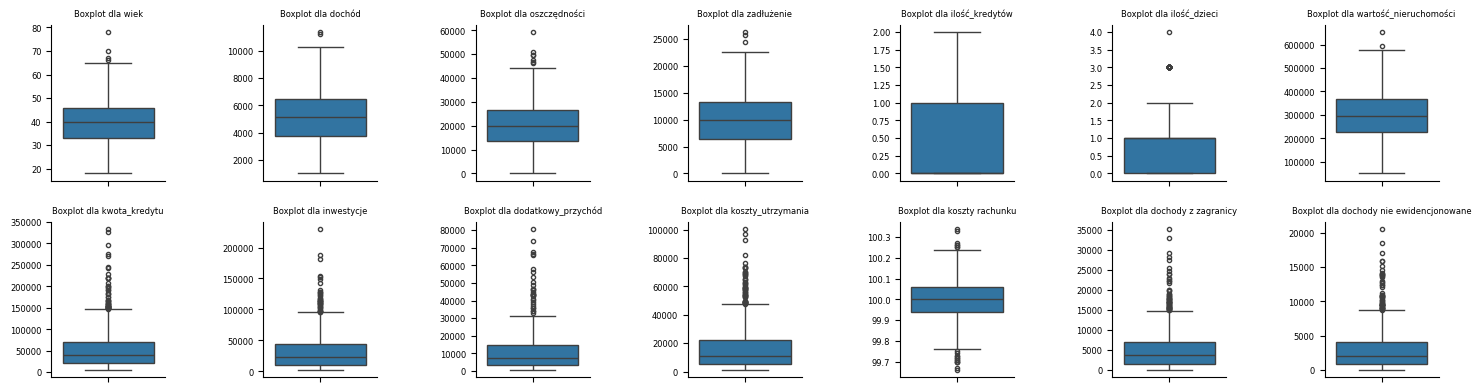

**Znaleziono 26 obserwacji odstających:**

### Wartości odstające przed transformacją

wiek    dochód  oszczędności  zadłużenie  ilość_kredytów  ilość_dzieci  \
0      44   7798.71      13248.22      460.96               0             0   
18     30   4359.31      26354.18     7744.21               0             1   
93     36   5103.89       8611.67    12098.05               1             2   
121    30   7374.06      27846.04     6939.17               0             2   
173    43   4874.81      21517.58    13880.14               0             1   
199    28   7728.28      24878.72    12186.57               1             1   
209    78   8499.15      19992.91    12256.13               0             1   
213    46   6789.85      15479.10    17616.19               0             1   
296    48   6838.15      24183.98    18381.97               0             1   
394    51   4269.36      19165.62    19862.71               1             0   
401    34   6073.31      21768.21    12848.80               1             0   
405    46   3486.41      33404.61        0.00               1             1   
478    70   3225.02       6613.94    15767.95               0             0   
561    60   3505.58      20856.87     6216.18               1             0   
613    28   4844.33      19934.79    11979.10               0             1   
615    41  11386.22      26683.40    13673.19               0             0   
677    57   8042.63       4351.97     9248.79               1             2   
716    41   5663.96      26255.08    26215.46               2             1   
752    30   3691.85      15341.94    16264.21               0             2   
796    39   4361.89      25731.28     9178.32               1             4   
867    43   7253.41      11133.19    18268.09               0             0   
925    24   3161.23      22522.40     8318.07               0             0   
952    27   3188.54      24666.71    20920.48               1             0   
957    44  11275.50      17634.45     8802.49               1             1   
963    47   6290.43       9434.42    13844.20               1             0   
982    30   3746.57      27324.92    25760.28               1             2   

     wartość_nieruchomości  kwota_kredytu  inwestycje  dodatkowy_przychód  \
0                188591.86        5487.39    41236.33             9972.89   
18               285265.98      107967.37     5059.39             2762.26   
93               212880.70      147894.01    12418.28              939.66   
121              314775.59        8857.38     2425.39            26280.46   
173              167950.66       40162.71    43848.54             4575.83   
199              264175.56       65560.67    58321.88             4539.31   
209              234025.14       67968.03    14363.64             4996.97   
213              169541.06       88361.44    23517.18             8099.94   
296              207086.37      122160.82    31860.09             9855.34   
394              209719.11       30884.95    30956.01             6304.47   
401              218598.93      121264.87   116871.13              612.62   
405              433696.91       10184.46    58051.37             2908.65   
478              275597.16        7568.06    22988.74            16505.83   
561              434609.98       19802.85    20438.91             1561.31   
613              519664.61       51952.27    23577.50             2248.22   
615              299828.58       13736.07    11585.62             4583.04   
677              210274.70       10401.23    58011.15             6363.50   
716              404839.99       65150.84    25072.01            23888.27   
752              273545.41       81253.88    68617.40             4845.30   
796              453914.23      175886.47    40774.52             3779.41   
867              219400.83       12943.72    17720.37             1685.59   
925              167844.42       26770.82    18850.17             4204.16   
952              153502.53       99184.43    28559.40            23830.55   
957              480608

**Przekształcono wartości odstające metodą winsoryzacji:**

### Wartości odstające po transformacji

wiek   dochód  oszczędności  zadłużenie  ilość_kredytów  ilość_dzieci  \
0      44  7798.71      13248.22     1068.12               0             0   
18     30  4359.31      26354.18     7744.21               0             1   
93     36  5103.89       8611.67    12098.05               1             2   
121    30  7374.06      27846.04     6939.17               0             2   
173    43  4874.81      21517.58    13880.14               0             1   
199    28  7728.28      24878.72    12186.57               1             1   
209    56  8390.10      19992.91    12256.13               0             1   
213    46  6789.85      15479.10    17616.19               0             1   
296    48  6838.15      24183.98    18345.35               0             1   
394    51  4269.36      19165.62    18345.35               1             0   
401    34  6073.31      21768.21    12848.80               1             0   
405    46  3486.41      33404.61     1068.12               1             1   
478    56  3225.02       6613.94    15767.95               0             0   
561    56  3505.58      20856.87     6216.18               1             0   
613    28  4844.33      19934.79    11979.10               0             1   
615    41  8390.10      26683.40    13673.19               0             0   
677    56  8042.63       4351.97     9248.79               1             2   
716    41  5663.96      26255.08    18345.35               1             1   
752    30  3691.85      15341.94    16264.21               0             2   
796    39  4361.89      25731.28     9178.32               1             2   
867    43  7253.41      11133.19    18268.09               0             0   
925    24  3161.23      22522.40     8318.07               0             0   
952    27  3188.54      24666.71    18345.35               1             0   
957    44  8390.10      17634.45     8802.49               1             1   
963    47  6290.43       9434.42    13844.20               1             0   
982    30  3746.57      27324.92    18345.35               1             2   

     wartość_nieruchomości  kwota_kredytu  inwestycje  dodatkowy_przychód  \
0                188591.86        7823.49    41236.33             9972.89   
18               285265.98      107967.37     5059.39             2762.26   
93               212880.70      147894.01    12418.28              939.66   
121              314775.59        8857.38     3471.47            26280.46   
173              167950.66       40162.71    43848.54             4575.83   
199              264175.56       65560.67    58321.88             4539.31   
209              234025.14       67968.03    14363.64             4996.97   
213              169541.06       88361.44    23517.18             8099.94   
296              207086.37      122160.82    31860.09             9855.34   
394              209719.11       30884.95    30956.01             6304.47   
401              218598.93      121264.87    89959.02              937.25   
405              433696.91       10184.46    58051.37             2908.65   
478              275597.16        7823.49    22988.74            16505.83   
561              434609.98       19802.85    20438.91             1561.31   
613              468149.25       51952.27    23577.50             2248.22   
615              299828.58       13736.07    11585.62             4583.04   
677              210274.70       10401.23    58011.15             6363.50   
716              404839.99       65150.84    25072.01            23888.27   
752              273545.41       81253.88    68617.40             4845.30   
796              453914.23      148158.69    40774.52             3779.41   
867              219400.83       12943.72    17720.37             1685.59   
925              167844.42       26770.82    18850.17             4204.16   
952              153502.53       99184.43    28559.40            23830.55   
957              468149.25      148158.69    16098

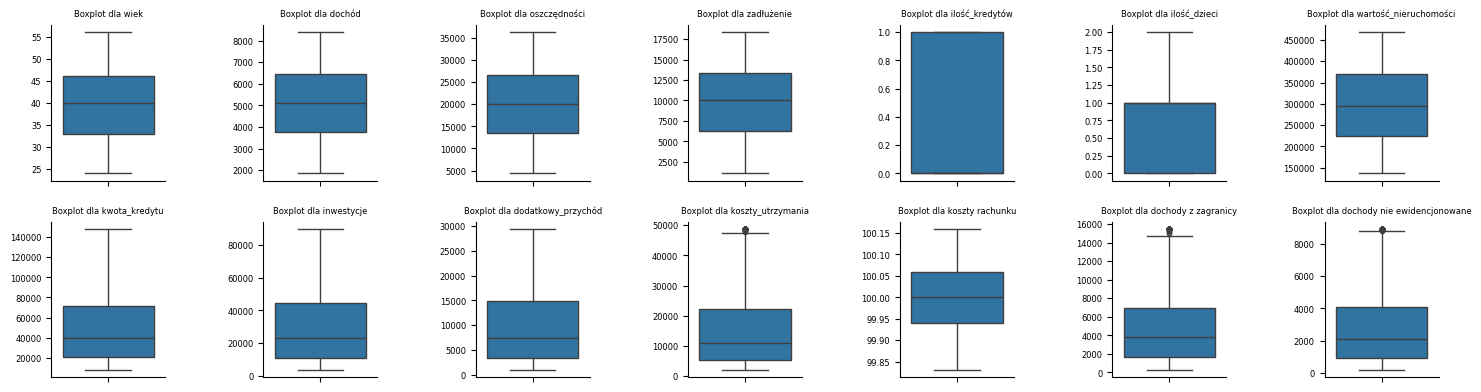

In [27]:

# ====================================================================
# Identyfikacja i obsługa wartości odstających
# ====================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from IPython.display import display, Markdown


display(Markdown('**Analiza wartości odstających:**'))
display(Markdown('- wartości odstające wykryte metodą (z_scores) > 3) zostaną przekształcone metodą winsoryzacji:'))

numeric_cols = X.select_dtypes(include=['number']).columns

# Tworzenie wykresów pudełkowych dla wszystkich zmiennych liczbowych
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 7) + 1, ncols=min(7, num_cols), figsize=(15, 2 * ((num_cols // 7) + 1)))
axes = axes.flatten() if num_cols > 1 else [axes]
for i, column in enumerate(numeric_cols):
    sns.boxplot(y=X[column], ax=axes[i], flierprops={'marker': 'o', 'color': 'red', 'markersize': 3})
    axes[i].set_title(f"Boxplot dla {column}")
    axes[i].set_xlabel("")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.title.set_fontsize(6)
    axes[i].set_ylabel("")
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.title.set_fontsize(6)
        ax.set_ylabel("")  # Remove y-axis label
        #ax.yaxis.set_visible(False)  # Hide y-axis ticks and labels
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
plt.show()



# Obliczenie Z-score dla zmiennych liczbowych
numeric_cols = X.select_dtypes(include=['number']).columns
z_scores = X[numeric_cols].apply(zscore)

# Wykrywanie obserwacji odstających (|Z-score| > 3)
outliers_mask = (np.abs(z_scores) > 3).any(axis=1)
display(Markdown(f'**Znaleziono {outliers_mask.sum()} obserwacji odstających:**'))
# Tworzenie tabeli przed transformacją
outliers_before = X.loc[outliers_mask, numeric_cols]
display(Markdown("### Wartości odstające przed transformacją"))
display(outliers_before)




# Usuwanie lub transformacja wartości odstających
decision = "transform"  # Można zmienić na "remove"

if decision == "remove":
    X = X[~outliers_mask]
    y = y[~outliers_mask]
    print("Usunięto obserwacje odstające")

elif decision == "transform":
    for col in numeric_cols:
        X[col] = winsorize(X[col], limits=[0.05, 0.05])
    display(Markdown(f'**Przekształcono wartości odstające metodą winsoryzacji:**'))
    # Tworzenie tabeli po transformacji
    outliers_after = X.loc[outliers_mask, numeric_cols]
    display(Markdown("### Wartości odstające po transformacji"))
    display(outliers_after)
    

# Tworzenie wykresów pudełkowych dla wszystkich zmiennych liczbowych
num_cols = len(numeric_cols)
fig, axes = plt.subplots(nrows=(num_cols // 7) + 1, ncols=min(7, num_cols), figsize=(15, 2 * ((num_cols // 7) + 1)))
axes = axes.flatten() if num_cols > 1 else [axes]
for i, column in enumerate(numeric_cols):
    sns.boxplot(y=X[column], ax=axes[i], flierprops={'marker': 'o', 'color': 'red', 'markersize': 3})
    axes[i].set_title(f"Boxplot dla {column}")
    axes[i].set_xlabel("")
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.title.set_fontsize(6)
    axes[i].set_ylabel("")
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=6)
        ax.title.set_fontsize(6)
        ax.set_ylabel("")  # Remove y-axis label
        #ax.yaxis.set_visible(False)  # Hide y-axis ticks and labels
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        #ax.spines['left'].set_visible(False)
        #ax.spines['bottom'].set_visible(False)
plt.show()


# Aktualizacja danych po zmianach
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)



#### 3.5 Identyfikacja zależności zmiennych numerycznych

**Identyfikacja korelacji zmiennych numerycznych:**

Macierz korelacji:


wiek    dochód  oszczędności  zadłużenie  \
wiek                         1.000000 -0.046639      0.024964   -0.014288   
dochód                      -0.046639  1.000000     -0.010178   -0.057793   
oszczędności                 0.024964 -0.010178      1.000000    0.028001   
zadłużenie                  -0.014288 -0.057793      0.028001    1.000000   
ilość_kredytów              -0.033285 -0.036383      0.030572    0.046840   
ilość_dzieci                -0.004130  0.024518     -0.022237    0.035293   
wartość_nieruchomości       -0.030030 -0.004762     -0.027681    0.011309   
kwota_kredytu               -0.006264  0.022782      0.000805    0.014149   
inwestycje                  -0.031703  0.008036      0.008326   -0.040385   
dodatkowy_przychód           0.055229 -0.003681     -0.027316   -0.027177   
koszty_utrzymania           -0.011509  0.036732     -0.080645    0.045472   
koszty rachunku              0.006703 -0.036670     -0.073243   -0.023470   
liczba wizyt w oddziale      0.051518  0.054777     -0.051948    0.009197   
dochody z zagranicy          0.036673 -0.022277      0.029832    0.005628   
dochody nie ewidencjonowane  0.034434 -0.012434     -0.006996    0.040392   
kredyt                      -0.006492  0.054433      0.151617   -0.219454   

                             ilość_kredytów  ilość_dzieci  \
wiek                              -0.033285     -0.004130   
dochód                            -0.036383      0.024518   
oszczędności                       0.030572     -0.022237   
zadłużenie                         0.046840      0.035293   
ilość_kredytów                     1.000000     -0.050875   
ilość_dzieci                      -0.050875      1.000000   
wartość_nieruchomości              0.005212      0.019430   
kwota_kredytu                      0.008814      0.013273   
inwestycje                         0.002883     -0.000255   
dodatkowy_przychód                 0.017065      0.024309   
koszty_utrzymania                 -0.036128      0.055334   
koszty rachunku                   -0.017176      0.012849   
liczba wizyt w oddziale           -0.067408      0.049479   
dochody z zagranicy                0.013275      0.015345   
dochody nie ewidencjonowane       -0.057005      0.020415   
kredyt                            -0.071738      0.013017   

                             wartość_nieruchomości  kwota_kredytu  inwestycje  \
wiek                                     -0.030030      -0.006264   -0.031703   
dochód                                   -0.004762       0.022782    0.008036   
oszczędności                             -0.027681       0.000805    0.008326   
zadłużenie                                0.011309       0.014149   -0.040385   
ilość_kredytów                            0.005212       0.008814    0.002883   
ilość_dzieci                              0.019430       0.013273   -0.000255   
wartość_nieruchomości                     1.000000       0.035759   -0.033775   
kwota_kredytu                             0.035759       1.000000   -0.060638   
inwestycje                               -0.033775      -0.060638    1.000000   
dodatkowy_przychód                        0.009160      -0.040581   -0.025145   
koszty_utrzymania                         0.020943       0.018862    0.008791   
koszty rachunku                          -0.029952      -0.007033   -0.034319   
liczba wizyt w oddziale                  -0.013657      -0.007249    0.040481   
dochody z zagranicy                       0.001931      -0.005624   -0.038507   
dochody nie ewidencjonowane              -0.053165      -0.049049   -0.014695   
kredyt                                    0.006162      -0.499861    0.181930   

                             dodatkowy_przychód  koszty_utrzymania  \
wiek                                   0.055229          -0.011509   
dochód                                -0.003681           0.036732   
oszczędności                          -0.027316          -0.080645   
zadłużenie                 

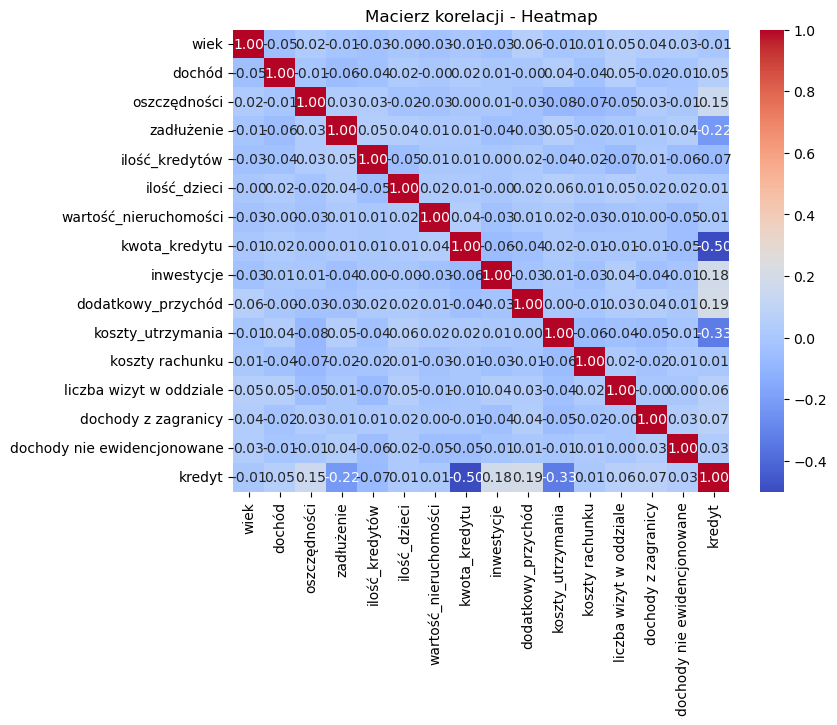

Brak zmiennych o korelacji powyżej progu 0.8.


**Podsumowanie po czyszczeniu danych :**

Ostateczny kształt danych: 1003 wierszy, 23 kolumn


In [28]:


# ====================================================================
# Identyfikacja korelacji zmiennych numerycznych
# ====================================================================

display(Markdown('**Identyfikacja korelacji zmiennych numerycznych:**'))

# Wybór tylko zmiennych numerycznych
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Obliczenie macierzy korelacji
corr_matrix = numeric_df.corr()

# Wyświetlenie macierzy korelacji
print("Macierz korelacji:")
display(corr_matrix)

# Wizualizacja macierzy korelacji
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Macierz korelacji - Heatmap")
plt.show()



# ====================================================================
# Identyfikacja skorelowanych zmiennych powyżej progu
# ====================================================================
threshold = 0.8  # Próg korelacji
high_corr_pairs = []

# Przeglądanie macierzy korelacji
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):  # Unikamy duplikatów (dolna trójkątna macierz)
        if abs(corr_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

# Wyświetlenie listy skorelowanych zmiennych
if high_corr_pairs:
    display(Markdown("### Zmienne o korelacji powyżej progu 0.8:"))
    for var1, var2, corr in high_corr_pairs:
        print(f"- {var1} i {var2}: korelacja {corr:.2f}")
else:
    print("Brak zmiennych o korelacji powyżej progu 0.8.")



# ====================================================================
# 4. Aktualizacja analiz po czyszczeniu danych
# ====================================================================
display(Markdown('**Podsumowanie po czyszczeniu danych :**'))

print(f"Ostateczny kształt danych: {X.shape[0]} wierszy, {X.shape[1]} kolumn")



#### 3.6 Identyfikacja zależności zmiennych nominalnych

Zmienna kategorialna  Liczba kategorii       Chi2  P-wartość  \
0       czy_karta_kredytowa                 2   0.501220   0.478964   
1  czy_korzysta_z_aplikacji                 2   1.280580   0.257791   
2             wykształcenie                 4   3.613424   0.306347   
3     sytuacja_mieszkaniowa                 3   0.308581   0.857023   
4       forma_wynagrodzenia                 3   0.500095   0.778764   
5            źródło_dochodu                10  12.192634   0.202666   
6        typ_zabezpieczenia                 3   8.457419   0.014571   
7        czy_aktywny_online                 2   0.126880   0.721689   
8         czy_ubezpieczenie                 2   9.978987   0.001583   

   V Cramera  \
0   0.022366   
1   0.035732   
2   0.060082   
3   0.017540   
4   0.022329   
5   0.110365   
6   0.091827   
7   0.011247   
8   0.099845   

                                                                                                                                                                                                                                                          Liczność kategorii  
0                                                                                                                                                                                                                                                   {'tak': 532, 'nie': 470}  
1                                                                                                                                                                                                                                                   {'Nie': 517, 'Tak': 486}  
2                                                                                                                                                                                                        {'zawodowe': 266, 'wyższe': 260, 'średnie': 242, 'podstawowe': 233}  
3                                                                                                                                                                                                             {'wynajem': 346, 'mieszkanie z rodzicami': 329, 'własne': 328}  
4                                                                                                                                                                                                                {'za wykonanie': 355, 'tygodniowe': 346, 'miesięczne': 302}  
5  {'Dochody z działalności gospodarczej': 180, 'Emerytura': 174, 'Renta': 170, 'Wynagrodzenie etatowe': 162, 'Wynagrodzenie za zlecenie': 140, 'Stypendium': 39, 'Dochody z najmu': 36, 'Wynagrodzenie za dzieło': 35, 'Dochody kapitałowe': 34, 'Inne źródło dochodu': 31}  
6                                                                                                                                                                                                             {'hipoteka': 344, 'gwarancja bankowa': 332, 'poręczenie': 327}  
7                                                                                                                                                                                                                                                   {'Tak': 505, 'Nie': 498}  
8                                                                                                                                                                                                                                                   {'tak': 512, 'nie': 489}

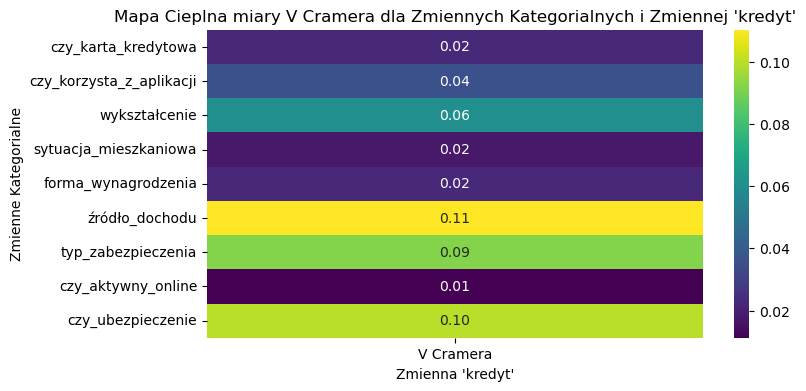

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns

def cramers_v(confusion_matrix):

    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    min_dim = min(confusion_matrix.shape) - 1
    # Zapobiega dzieleniu przez zero
    if n == 0 or min_dim == 0:
        return 0.0
    else:
        return np.sqrt((chi2 / n) / min_dim)

def analiza_korelacji_kredyt_kategoria(df, zmienne_kategorialne, kredyt_zmienna='kredyt'):

    wyniki = []
    for zmienna in zmienne_kategorialne:
        # 1. Obliczenie tabeli kontyngencji
        tab_kont = pd.crosstab(df[zmienna], df[kredyt_zmienna])

        # 2. Wykonanie testu chi-kwadrat
        chi2, p, dof, oczekiwane = chi2_contingency(tab_kont)

        # 3. Obliczenie V Cramera
        v_cramer = cramers_v(tab_kont.values) # Dodano obliczenie V Cramera

        # 4. Obliczenie średniego kredytu dla każdej kategorii
        sredni_kredyt = df.groupby(zmienna)[kredyt_zmienna].mean()
        licznosc_kategorii = df[zmienna].value_counts()

        # Dodanie wyników do listy
        wyniki.append({
            'Zmienna kategorialna': zmienna,
            'Liczba kategorii': len(tab_kont),
            'Chi2': chi2,
            'P-wartość': p,
            'V Cramera': v_cramer, # Dodano V Cramera do wyników
            #'Średni kredyt dla kategorii': sredni_kredyt.to_dict(), # Usunięto kolumnę z wynikami
            'Liczność kategorii': licznosc_kategorii.to_dict()
        })

    # Konwersja wyników na DataFrame
    wyniki_df = pd.DataFrame(wyniki)
    return wyniki_df

def wizualizacja_korelacji_kredyt_kategoria(df, wyniki_df, kredyt_zmienna='kredyt'):

    # Przygotowanie danych do mapy cieplnej
    cramer_matrix = pd.DataFrame(index=wyniki_df['Zmienna kategorialna'], columns=['V Cramera'])
    for index, row in wyniki_df.iterrows():
        cramer_matrix.loc[row['Zmienna kategorialna'], 'V Cramera'] = row['V Cramera']

    # Konwersja kolumny 'V Cramera' na typ numeryczny
    cramer_matrix['V Cramera'] = pd.to_numeric(cramer_matrix['V Cramera'], errors='coerce')

    # Mapa cieplna
    plt.figure(figsize=(8, 4))
    sns.heatmap(cramer_matrix, annot=True, cmap='viridis', fmt=".2f")
    plt.title("Mapa Cieplna miary V Cramera dla Zmiennych Kategorialnych i Zmiennej 'kredyt'")
    plt.xlabel("Zmienna 'kredyt'")
    plt.ylabel("Zmienne Kategorialne")
    plt.show()


zmienne_kategorialne = ['czy_karta_kredytowa', 'czy_korzysta_z_aplikacji', 'wykształcenie', 'sytuacja_mieszkaniowa', 'forma_wynagrodzenia', 'źródło_dochodu', 'typ_zabezpieczenia', 'czy_aktywny_online', 'czy_ubezpieczenie']
wyniki_analizy = analiza_korelacji_kredyt_kategoria(df, zmienne_kategorialne)
display(wyniki_analizy)
wizualizacja_korelacji_kredyt_kategoria(df, wyniki_analizy)


# III. Tworzenia modelu klasyfikacyjnego

### 1.Wydzielenie ze zbioru zmienych objaśniających [X] oraz zmiennej celu [Y]

> Podział zbioru danych na:

- Zmienną docelową (y) – zawierającą wartości kolumny 'kredyt', którą chcemy przewidywać.

- Zmiennie objaśniające (X) – czyli wszystkie pozostałe kolumny oprócz 'kredyt', które będą używane jako cechy wejściowe do modelu predykcyjnego.

In [41]:

# Wydzielenie X (zmienne objaśniające) i y (zmienna docelowa)
X = df.drop('kredyt', axis=1)
y = df['kredyt']



# Tworzenie DataFrame z nazwami zmiennych predykcyjnych i zmiennej celu
variables_info = {
    'Zmienne predykcyjne': X.columns.tolist(),
    'Zmienna celu': [y.name]
}
variables_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in variables_info.items()]))
variables_df = variables_df.fillna('')  # Zamiana NaN na pusty wiersz
display(Markdown('**Nazwy zmiennych predykcyjnych i zmiennej celu:**'))
display(variables_df)




**Nazwy zmiennych predykcyjnych i zmiennej celu:**

Zmienne predykcyjne Zmienna celu
0                          wiek       kredyt
1                        dochód             
2                  oszczędności             
3                    zadłużenie             
4                ilość_kredytów             
5                  ilość_dzieci             
6         wartość_nieruchomości             
7                 kwota_kredytu             
8                    inwestycje             
9            dodatkowy_przychód             
10            koszty_utrzymania             
11          czy_karta_kredytowa             
12            czy_ubezpieczenie             
13              koszty rachunku             
14      liczba wizyt w oddziale             
15          dochody z zagranicy             
16  dochody nie ewidencjonowane             
17                wykształcenie             
18        sytuacja_mieszkaniowa             
19          forma_wynagrodzenia             
20               źródło_dochodu             
21           typ_zabezpieczenia             
22           czy_aktywny_online             
23     czy_korzysta_z_aplikacji

### 2.Podział danych na zbiory treningowy,  testowy

> Podział danych na zbiór treningowy i testowy jest kluczowy w uczeniu maszynowym, ponieważ pozwala ocenić rzeczywistą skuteczność modelu na nowych, niewidzianych wcześniej danych.
- Uniknięcie przeuczenia (overfittingu) – trenując model tylko na części danych, możemy ocenić jego jakość na niezależnym zbiorze testowym.
- Poprawna ocena modelu – zbiór testowy symuluje nowe, nieznane dane i pozwala sprawdzić, jak model generalizuje.
- Zachowanie proporcji klas (stratify=y) – zapewnia realistyczne warunki dla algorytmu uczenia maszynowego, szczególnie ważne przy niezrównoważonych klasach.



In [42]:


# ====================================================================
# 2. Podział danych na zbiory treningowy,  testowy
# ====================================================================


# Podział danych na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)


# Tworzenie słownika z rozmiarami zbiorów danych
shape_dict = {
    "Dane": ["X - zmienna objaśniacjąca (cały zbiór)", "y - zmienna celu  (cały zbiór)", "X_train", "y_train", "X_test", "y_test"],
    "Rozmiar": [X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape],
}

print()
# Tworzenie DataFrame z rozmiarami zbiorów danych
shape_df = pd.DataFrame(shape_dict)
# Wyświetlenie DataFrame z rozmiarami zbiorów danych
print("Rozmiary zbiorów danych:")
display(shape_df)




# Tworzenie słownika z proporcjami zmiennej docelowej w zbiorach danych
prop_y = {
    'Struktura danych "y_train"': y_train.value_counts(normalize=True) * 100,
    'Struktura danych "y_test"': y_test.value_counts(normalize=True) * 100,
}
print()
# Tworzenie DataFrame z proporcjami zmiennej docelowej
proporcje_y = pd.DataFrame(prop_y)
# Wyświetlenie DataFrame z proporcjami zmiennej docelowej, zaokrąglonymi do dwóch miejsc po przecinku
print("Proporcje zmiennej docelowej w zbiorach danych:")
display(proporcje_y.round(2))
print()
# Obliczanie struktury danych
data_structure_info = {
    'Zbiór danych': ['X_train', 'X_test'],
    'Procent danych': [
        (X_train.shape[0] / X.shape[0]) * 100,
        (X_test.shape[0] / X.shape[0]) * 100,
    ],
}

print()


import altair as alt
import pandas as pd

# Tworzenie DataFrame
counts = y_train.value_counts().reset_index()
counts.columns = ['Klasa', 'Liczność']
counts['Procent'] = counts['Liczność'] / counts['Liczność'].sum() * 100

# Tworzenie wykresu
chart = (
    alt.Chart(counts)
    .mark_bar()
    .encode(
        x=alt.X('Klasa:N', title='Klasa'),
        y=alt.Y('Liczność:Q', title='Liczność'),
        color=alt.Color('Klasa:N', scale=alt.Scale(scheme='set2')),
        tooltip=['Klasa', 'Liczność', 'Procent']
    )
)

# Dodanie wartości procentowych
text = (
    alt.Chart(counts)
    .mark_text(dy=-10)
    .encode(
        x=alt.X('Klasa:N'),
        y=alt.Y('Liczność:Q'),
        text=alt.Text('Procent:Q', format='.1f')
    )
)

# Wyświetlenie wykresu
(chart + text).properties(title='Rozkład klas w zbiorze treningowym', width=500, height=200).interactive()





Rozmiary zbiorów danych:


Dane     Rozmiar
0  X - zmienna objaśniacjąca (cały zbiór)  (1003, 24)
1          y - zmienna celu  (cały zbiór)     (1003,)
2                                 X_train   (802, 24)
3                                 y_train      (802,)
4                                  X_test   (201, 24)
5                                  y_test      (201,)


Proporcje zmiennej docelowej w zbiorach danych:


Struktura danych "y_train"  Struktura danych "y_test"
kredyt                                                       
0                             52.0                      51.74
1                             48.0                      48.26

alt.LayerChart(...)

### 3.Preprocesing danych

#### 3.1. Utworzenie struktury przepływ przekształceń

> Przekształcanie danych poprzez imputację braków, kodowanie cech kategorycznych, skalowanie, binaryzację, grupowanie wieku, transformację zmiennych skośnych oraz tworzenie transformerów, zapewni kompleksowe przygotowanie danych do modelowania.

In [43]:


# ====================================================================
# 3. Przetwarzanie danych
# ====================================================================


import pandas as pd

# Definiujemy dane
data = [
    ('czy_karta_kredytowa', 'binarna (kategoryczna)', 'Kodowanie wartości na 0 (Nie) i 1 (Tak)', 
     'Binarizer', 'SimpleImputer (most_frequent)'),
    ('czy_ubezpieczenie', 'binarna (kategoryczna)', 'Kodowanie wartości na 0 (Nie) i 1 (Tak)', 
     'Binarizer', 'SimpleImputer (most_frequent)'),
    ('czy_aktywny_online', 'binarna (kategoryczna)', 'Kodowanie wartości na 0 (Nie) i 1 (Tak)', 
     'Binarizer', 'SimpleImputer (most_frequent)'),
    ('czy_korzysta_z_aplikacji', 'binarna (kategoryczna)', 'Kodowanie wartości na 0 (Nie) i 1 (Tak)', 
     'Binarizer', 'SimpleImputer (most_frequent)'),
    ('wykształcenie', 'porządkowa (kategoryczna)', 
     'Przekształcenie kategorii na wartości liczbowe według hierarchii: podstawowe < zawodowe < średnie < wyższe', 
     'OrdinalEncoder', 'SimpleImputer (most_frequent)'),
    ('typ_zabezpieczenia', 'nominalna (kategoryczna)', 'Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)', 
     'OneHotEncoder', 'SimpleImputer (most_frequent)'),
    ('sytuacja_mieszkaniowa', 'nominalna (kategoryczna)', 'Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)', 
     'OneHotEncoder', 'SimpleImputer (most_frequent)'),
    ('forma_wynagrodzenia', 'nominalna (kategoryczna)', 'Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)', 
     'OneHotEncoder', 'SimpleImputer (most_frequent)'),
    ('ilość_kredytów', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),
    ('liczba wizyt w oddziale', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),
    ('koszty rachunku', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('zadłużenie', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('oszczędności', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('wartość_nieruchomości', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('dochody nie ewidencjonowane', 'binarna (kategoryczna)', 'Binarizacja wartości', 
     'Binarizer', 'SimpleImputer (most_frequent)'),

    ('źródło_dochodu', 'nominalna (kategoryczna)', 'Transformacja rzadkich wartości', 
     'Custom Transformer', 'SimpleImputer (most_frequent)'),

    ('wiek', 'numeryczna (kategoryczna)', 'Podział na przedziały wiekowe (14-22, 23-39, 40-64, >65)', 
     'pd.cut()', 'SimpleImputer (most_frequent)'),

    ('dochód', 'numeryczna', 'Obliczenie dochodu na osobę (dochód/liczba osób)', 
     'Custom Transformer: DochodNaOsobe', 'SimpleImputer (mean)'),

    ('ilość_dzieci', 'numeryczna', 'Wykorzystanie w obliczeniach dochodu na osobę', 
     'Custom Transformer: DochodNaOsobe', 'SimpleImputer (mean)'),

    ('kwota_kredytu', 'numeryczna', 'Obliczenie stosunku kwoty kredytu do wartości nieruchomości', 
     'Custom Transformer: StosunekKredytuDoNieruchomosci', 'SimpleImputer (mean)'),

    ('koszty_utrzymania', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('inwestycje', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)'),

    ('dodatkowy_przychód', 'numeryczna', 'Standaryzacja wartości do rozkładu N(0,1)', 
     'StandardScaler', 'SimpleImputer (mean)')
]

# Tworzenie DataFrame połączoną kolumną 'typ zmiennej' i bez 'Pipeline'
df = pd.DataFrame(data, columns=[
    'nazwa zmiennej', 'typ zmiennej', 'rodzaj przekształcenia', 
    'funkcja w Pythonie użyta do przekształcenia', 'imputacja braków'
])

# Ustawienie opcji wyświetlania, aby zawijać długie teksty
pd.set_option('display.max_colwidth', None)



print("Preprocesing danych - Zestawienie dokonanych przekształceń na danych:")

# Wyświetlenie tabeli
display(df)



Preprocesing danych - Zestawienie dokonanych przekształceń na danych:


nazwa zmiennej               typ zmiennej  \
0           czy_karta_kredytowa     binarna (kategoryczna)   
1             czy_ubezpieczenie     binarna (kategoryczna)   
2            czy_aktywny_online     binarna (kategoryczna)   
3      czy_korzysta_z_aplikacji     binarna (kategoryczna)   
4                 wykształcenie  porządkowa (kategoryczna)   
5            typ_zabezpieczenia   nominalna (kategoryczna)   
6         sytuacja_mieszkaniowa   nominalna (kategoryczna)   
7           forma_wynagrodzenia   nominalna (kategoryczna)   
8                ilość_kredytów                 numeryczna   
9       liczba wizyt w oddziale                 numeryczna   
10              koszty rachunku                 numeryczna   
11                   zadłużenie                 numeryczna   
12                 oszczędności                 numeryczna   
13        wartość_nieruchomości                 numeryczna   
14  dochody nie ewidencjonowane     binarna (kategoryczna)   
15               źródło_dochodu   nominalna (kategoryczna)   
16                         wiek  numeryczna (kategoryczna)   
17                       dochód                 numeryczna   
18                 ilość_dzieci                 numeryczna   
19                kwota_kredytu                 numeryczna   
20            koszty_utrzymania                 numeryczna   
21                   inwestycje                 numeryczna   
22           dodatkowy_przychód                 numeryczna   

                                                                                        rodzaj przekształcenia  \
0                                                                      Kodowanie wartości na 0 (Nie) i 1 (Tak)   
1                                                                      Kodowanie wartości na 0 (Nie) i 1 (Tak)   
2                                                                      Kodowanie wartości na 0 (Nie) i 1 (Tak)   
3                                                                      Kodowanie wartości na 0 (Nie) i 1 (Tak)   
4   Przekształcenie kategorii na wartości liczbowe według hierarchii: podstawowe < zawodowe < średnie < wyższe   
5                                                 Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)   
6                                                 Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)   
7                                                 Zamiana kategorii na zestaw zmiennych 0/1 (one-hot encoding)   
8                                                                    Standaryzacja wartości do rozkładu N(0,1)   
9                                                                    Standaryzacja wartości do rozkładu N(0,1)   
10                                                                   Standaryzacja wartości do rozkładu N(0,1)   
11                                                                   Standaryzacja wartości do rozkładu N(0,1)   
12                                                                   Standaryzacja wartości do rozkładu N(0,1)   
13                                                                   Standaryzacja wartości do rozkładu N(0,1)   
14                                                                                        Binarizacja wartości   
15                                                                             Transformacja rzadkich wartości   
16                                                    Podział na przedziały wiekowe (14-22, 23-39, 40-64, >65)   
17                                                            Obliczenie dochodu na osobę (dochód/liczba osób)   
18                                                               Wykorzystanie w obliczeniach dochodu na osobę   
19                                                 Obliczenie stosunku kwoty kredytu do wartości nieruchomości   
20                                                                   Standaryzacja wartości do rozkładu N(0,1)   
21                  

Cel: Przygotowanie danych do analizy poprzez transformację różnych typów zmiennych do formatu numerycznego, co jest wymagane przez większość algorytmów uczenia maszynowego

In [44]:

# przypisanie zmiennych do kategorii 

# binary_features = ['czy_karta_kredytowa', 'czy_ubezpieczenie', 'czy_aktywny_online', 'czy_korzysta_z_aplikacji']
# ordinal_features = ['wykształcenie']
# onehot_features = ['typ_zabezpieczenia', 'sytuacja_mieszkaniowa', 'forma_wynagrodzenia']
# binarize_feature = ['dochody nie ewidencjonowane']
# ohe_rare_feature = ['źródło_dochodu']
# numeric_features = ['ilość_kredytów', 'liczba wizyt w oddziale', 'koszty rachunku','zadłużenie', 'oszczędności','wartość_nieruchomości']
# income_cols = ['dochód', 'ilość_dzieci']
# skewed_features = ['dodatkowy_przychód', 'dochody z zagranicy', 'kwota_kredytu', 'koszty_utrzymania',   'inwestycje' ]



# Funkcja do grupowania wiekowego
def create_age_groups(X):
    bins = [14, 23, 40, 65, 105]
    labels = ['14-22', '23-39', '40-64', '> 65']
    return pd.DataFrame(pd.cut(X['wiek'], bins=bins, labels=labels))



# Klasa transformera dochodu na osobę
class IncomePerPerson(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = StandardScaler()
        self.power_transformer = PowerTransformer(method='yeo-johnson', standardize=True)

    def fit(self, X, y=None):
        X_imputed = self.imputer.fit_transform(X)
        X_temp = pd.DataFrame(X_imputed, columns=['dochód', 'ilość_dzieci'])
        X_temp['dochód_na_osobę'] = X_temp['dochód'] / X_temp['ilość_dzieci'].replace(0, np.nan)
        self.scaler.fit(X_temp[['dochód_na_osobę']].fillna(0))
        self.power_transformer.fit(X_temp[['dochód_na_osobę']].fillna(0))
        return self

    def transform(self, X):
        X_imputed = self.imputer.transform(X)
        X_temp = pd.DataFrame(X_imputed, columns=['dochód', 'ilość_dzieci'])
        X_temp['dochód_na_osobę'] = X_temp['dochód'] / X_temp['ilość_dzieci'].replace(0, np.nan)
        X_temp['dochód_na_osobę'].fillna(0, inplace=True)
        X_temp['dochód_na_osobę'] = self.power_transformer.transform(X_temp[['dochód_na_osobę']])
        return self.scaler.transform(X_temp[['dochód_na_osobę']])
    

# Tworzenie pipeline'ów
binary_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(),
    Binarizer(threshold=0.5)
)
ordinal_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(categories=[['podstawowe', 'zawodowe', 'średnie', 'wyższe']], dtype=int)
)

ohe_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False)
)

ohe_rare_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False, min_frequency=0.05, dtype=int)
)
numeric_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

binarizer_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    Binarizer(threshold=1500)
)
skewed_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'),
    PowerTransformer(method='yeo-johnson', standardize=True)
)
income_per_person_pipeline = make_pipeline(
    IncomePerPerson()
)

age_groups_pipeline = make_pipeline(
    FunctionTransformer(create_age_groups),
    OrdinalEncoder(categories=[['14-22', '23-39', '40-64', '> 65']], dtype=int,)
)


### 5. Pełny przepływ modelu

> Tworzenie pełnego pipeline’u z dla róznych modeli klasyfikacyjnych
- preprocesorem
- selektorem
- klassyfikatorem


#### 5.1. Tworzenie preprocesora

In [46]:

# Łączenie pipeline'ów w ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('binary', binary_pipeline, ['czy_karta_kredytowa', 'czy_ubezpieczenie', 'czy_aktywny_online', 'czy_korzysta_z_aplikacji']),
        ('ordinal', ordinal_pipeline, ['wykształcenie']),
        ('onehot', ohe_pipeline, ['typ_zabezpieczenia', 'sytuacja_mieszkaniowa', 'forma_wynagrodzenia']),
        ('numeric', numeric_pipeline, ['ilość_kredytów', 'koszty rachunku', 'zadłużenie', 'oszczędności', 'wartość_nieruchomości']),
        ('binarize', binarizer_pipeline, ['dochody nie ewidencjonowane']),
        ('oherare', ohe_rare_pipeline, ['źródło_dochodu']),
        ('wiek_grupy', age_groups_pipeline, ['wiek']),
        ('dochod_na_osobe', income_per_person_pipeline, ['dochód', 'ilość_dzieci']),
        ('skewed', skewed_pipeline, ['dodatkowy_przychód', 'dochody z zagranicy', 'kwota_kredytu', 'koszty_utrzymania', 'inwestycje'])
    ],
    remainder='passthrough'
)

# Tworzenie DataFrame z elementami preprocesora
preprocessor_elements = []

for name, pipeline, features in preprocessor.transformers:
    if name != 'remainder':  # Pomijamy kolumny, które są przekazywane bez zmian
        for step_name, step in pipeline.steps:
            preprocessor_elements.append({
                'Nazwa transformacji': name,
                'Funkcja': step_name,
                'Typ transformacji': type(step).__name__,
                'Zmienione cechy': ', '.join(features)
            })

preprocessor_df = pd.DataFrame(preprocessor_elements)
# Tworzenie DataFrame z nazwami kroków i nazwami pipeline'ów
column_transformer_steps = []

for name, pipeline, features in preprocessor.transformers:
    if name != 'remainder':  # Pomijamy kolumny przekazywane bez zmian
        column_transformer_steps.append({
            'Nazwa transformacji': name,
            'Kroki w pipeline': ' -> '.join([step_name for step_name, _ in pipeline.steps])
        })

steps_df = pd.DataFrame(column_transformer_steps)

# Wyświetlenie DataFrame
display(Markdown('**Kroki w ColumnTransformer:**'))
display(steps_df)
display(Markdown('**Elementy preprocesora:**'))
display(preprocessor_df)
print()


# Transformacja danych przy użyciu preprocesora
X_transformed = preprocessor.fit_transform(X_train)

print("Dane po przekształceniu:")
display(X_transformed.head().T)

print()
# # Transformacja danych przy użyciu preprocesora
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test) # Transformacja danych testowych
print()

print("Diagram przepływu przekształceń:")

display(preprocessor)


**Kroki w ColumnTransformer:**

Nazwa transformacji                              Kroki w pipeline
0              binary  simpleimputer -> ordinalencoder -> binarizer
1             ordinal               simpleimputer -> ordinalencoder
2              onehot                simpleimputer -> onehotencoder
3             numeric               simpleimputer -> standardscaler
4            binarize                    simpleimputer -> binarizer
5             oherare                simpleimputer -> onehotencoder
6          wiek_grupy         functiontransformer -> ordinalencoder
7     dochod_na_osobe                               incomeperperson
8              skewed             simpleimputer -> powertransformer

**Elementy preprocesora:**

Nazwa transformacji              Funkcja    Typ transformacji  \
0               binary        simpleimputer        SimpleImputer   
1               binary       ordinalencoder       OrdinalEncoder   
2               binary            binarizer            Binarizer   
3              ordinal        simpleimputer        SimpleImputer   
4              ordinal       ordinalencoder       OrdinalEncoder   
5               onehot        simpleimputer        SimpleImputer   
6               onehot        onehotencoder        OneHotEncoder   
7              numeric        simpleimputer        SimpleImputer   
8              numeric       standardscaler       StandardScaler   
9             binarize        simpleimputer        SimpleImputer   
10            binarize            binarizer            Binarizer   
11             oherare        simpleimputer        SimpleImputer   
12             oherare        onehotencoder        OneHotEncoder   
13          wiek_grupy  functiontransformer  FunctionTransformer   
14          wiek_grupy       ordinalencoder       OrdinalEncoder   
15     dochod_na_osobe      incomeperperson      IncomePerPerson   
16              skewed        simpleimputer        SimpleImputer   
17              skewed     powertransformer     PowerTransformer   

                                                                          Zmienione cechy  
0    czy_karta_kredytowa, czy_ubezpieczenie, czy_aktywny_online, czy_korzysta_z_aplikacji  
1    czy_karta_kredytowa, czy_ubezpieczenie, czy_aktywny_online, czy_korzysta_z_aplikacji  
2    czy_karta_kredytowa, czy_ubezpieczenie, czy_aktywny_online, czy_korzysta_z_aplikacji  
3                                                                           wykształcenie  
4                                                                           wykształcenie  
5                          typ_zabezpieczenia, sytuacja_mieszkaniowa, forma_wynagrodzenia  
6                          typ_zabezpieczenia, sytuacja_mieszkaniowa, forma_wynagrodzenia  
7        ilość_kredytów, koszty rachunku, zadłużenie, oszczędności, wartość_nieruchomości  
8        ilość_kredytów, koszty rachunku, zadłużenie, oszczędności, wartość_nieruchomości  
9                                                             dochody nie ewidencjonowane  
10                                                            dochody nie ewidencjonowane  
11                                                                         źródło_dochodu  
12                                                                         źródło_dochodu  
13                                                                                   wiek  
14                                                                                   wiek  
15                                                                   dochód, ilość_dzieci  
16  dodatkowy_przychód, dochody z zagranicy, kwota_kredytu, koszty_utrzymania, inwestycje  
17  dodatkowy_przychód, dochody z zagranicy, kwota_kredytu, koszty_utrzymania, inwestycje


Dane po przekształceniu:


913  \
binary__czy_karta_kredytowa                                   1.000000   
binary__czy_ubezpieczenie                                     0.000000   
binary__czy_aktywny_online                                    0.000000   
binary__czy_korzysta_z_aplikacji                              1.000000   
ordinal__wykształcenie                                        2.000000   
onehot__typ_zabezpieczenia_gwarancja bankowa                  1.000000   
onehot__typ_zabezpieczenia_hipoteka                           0.000000   
onehot__typ_zabezpieczenia_poręczenie                         0.000000   
onehot__sytuacja_mieszkaniowa_mieszkanie z rodzicami          0.000000   
onehot__sytuacja_mieszkaniowa_wynajem                         0.000000   
onehot__sytuacja_mieszkaniowa_własne                          1.000000   
onehot__forma_wynagrodzenia_miesięczne                        1.000000   
onehot__forma_wynagrodzenia_tygodniowe                        0.000000   
onehot__forma_wynagrodzenia_za wykonanie                      0.000000   
numeric__ilość_kredytów                                       0.882645   
numeric__koszty rachunku                                      0.792122   
numeric__zadłużenie                                          -0.819218   
numeric__oszczędności                                         0.798936   
numeric__wartość_nieruchomości                                1.181465   
binarize__dochody nie ewidencjonowane                         0.000000   
oherare__źródło_dochodu_Dochody z działalności gospodarczej   0.000000   
oherare__źródło_dochodu_Emerytura                             0.000000   
oherare__źródło_dochodu_Renta                                 1.000000   
oherare__źródło_dochodu_Wynagrodzenie etatowe                 0.000000   
oherare__źródło_dochodu_Wynagrodzenie za zlecenie             0.000000   
oherare__źródło_dochodu_infrequent_sklearn                    0.000000   
wiek_grupy__wiek                                              2.000000   
dochod_na_osobe__dochód_na_osobę                             -1.046229   
skewed__dodatkowy_przychód                                   -1.689096   
skewed__dochody z zagranicy                                  -0.952073   
skewed__kwota_kredytu                                         0.357039   
skewed__koszty_utrzymania                                    -0.453562   
skewed__inwestycje                                           -0.376359   
remainder__liczba wizyt w oddziale                           49.980000   

                                                                   365  \
binary__czy_karta_kredytowa                                   1.000000   
binary__czy_ubezpieczenie                                     1.000000   
binary__czy_aktywny_online                                    0.000000   
binary__czy_korzysta_z_aplikacji                              0.000000   
ordinal__wykształcenie                                        3.000000   
onehot__typ_zabezpieczenia_gwarancja bankowa                  0.000000   
onehot__typ_zabezpieczenia_hipoteka                           1.000000   
onehot__typ_zabezpieczenia_poręczenie                         0.000000   
onehot__sytuacja_mieszkaniowa_mieszkanie z rodzicami          0.000000   
onehot__sytuacja_mieszkaniowa_wynajem                         0.000000   
onehot__sytuacja_mieszkaniowa_własne                          1.000000   
onehot__forma_wynagrodzenia_miesięczne                        0.000000   
onehot__forma_wynagrodzenia_tygodniowe                        0.000000   
onehot__forma_wynagrodzenia_za wykonanie                      1.000000   
numeric__ilość_kredytów                                       2.750404   
numeric__koszty rachunku                                     -0.735052   
numeric__zadłużenie                                           1.991869   
numeric__oszczędności                                         1.613935   
numeric__wartość_nieruchomości                                1.805455



Diagram przepływu przekształceń:


ColumnTransformer(remainder='passthrough',
                  transformers=[('binary',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder()),
                                                 ('binarizer',
                                                  Binarizer(threshold=0.5))]),
                                 ['czy_karta_kredytowa', 'czy_ubezpieczenie',
                                  'czy_aktywny_online',
                                  'czy_korzysta_z_aplikacji']),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimput...
                                                                              '23-39',
                                                                              '40-64',
                                                                              '> '
                                                                              '65']],
                                                                 dtype=<class 'int'>))]),
                                 ['wiek']),
                                ('dochod_na_osobe',
                                 Pipeline(steps=[('incomeperperson',
                                                  IncomePerPerson())]),
                                 ['dochód', 'ilość_dzieci']),
                                ('skewed',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('powertransformer',
                                                  PowerTransformer())]),
                                 ['dodatkowy_przychód', 'dochody z zagranicy',
                                  'kwota_kredytu', 'koszty_utrzymania',
                                  'inwestycje'])])

### 4.Selekcja danych



#### 4.1. Ważnosć cech - wg modelu Random Forest

Feature  Importance
30                                        skewed__kwota_kredytu    0.284308
31                                    skewed__koszty_utrzymania    0.129690
16                                          numeric__zadłużenie    0.069330
28                                   skewed__dodatkowy_przychód    0.062352
17                                        numeric__oszczędności    0.052736
32                                           skewed__inwestycje    0.048836
29                                  skewed__dochody z zagranicy    0.043522
33                           remainder__liczba wizyt w oddziale    0.039338
18                               numeric__wartość_nieruchomości    0.039319
27                             dochod_na_osobe__dochód_na_osobę    0.039256
15                                     numeric__koszty rachunku    0.032868
4                                        ordinal__wykształcenie    0.013296
26                                             wiek_grupy__wiek    0.010398
1                                     binary__czy_ubezpieczenie    0.010384
14                                      numeric__ilość_kredytów    0.009254
5                  onehot__typ_zabezpieczenia_gwarancja bankowa    0.007555
2                                    binary__czy_aktywny_online    0.007508
19                        binarize__dochody nie ewidencjonowane    0.007415
13                     onehot__forma_wynagrodzenia_za wykonanie    0.007222
3                              binary__czy_korzysta_z_aplikacji    0.006910
22                                oherare__źródło_dochodu_Renta    0.006857
10                         onehot__sytuacja_mieszkaniowa_własne    0.006604
21                            oherare__źródło_dochodu_Emerytura    0.006517
9                         onehot__sytuacja_mieszkaniowa_wynajem    0.006375
7                         onehot__typ_zabezpieczenia_poręczenie    0.005986
6                           onehot__typ_zabezpieczenia_hipoteka    0.005949
8          onehot__sytuacja_mieszkaniowa_mieszkanie z rodzicami    0.005724
11                       onehot__forma_wynagrodzenia_miesięczne    0.005412
24            oherare__źródło_dochodu_Wynagrodzenie za zlecenie    0.005209
0                                   binary__czy_karta_kredytowa    0.005202
12                       onehot__forma_wynagrodzenia_tygodniowe    0.005073
20  oherare__źródło_dochodu_Dochody z działalności gospodarczej    0.005002
25                   oherare__źródło_dochodu_infrequent_sklearn    0.004649
23                oherare__źródło_dochodu_Wynagrodzenie etatowe    0.003942

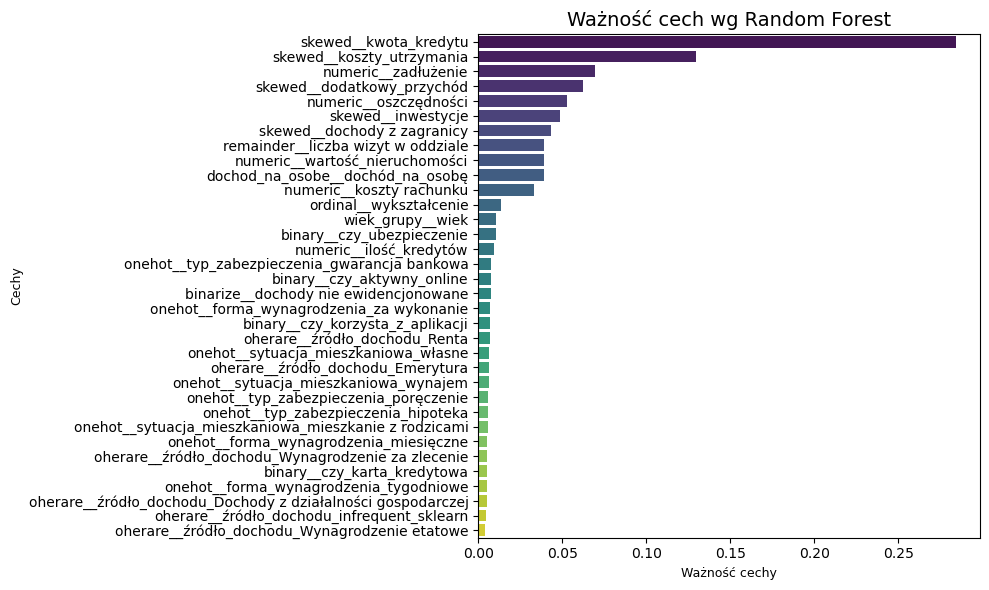

In [48]:

# ====================================================================
# SELEKCJA CECH (WAŻNOŚĆ CECH RANDOM FOREST)
# ====================================================================

# Inicjalizacja klasyfikatora Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Utworzenie obiektu SelectFromModel
feature_selection_rf = SelectFromModel(rf, threshold= 0.005)  # Możesz dostosować próg



# Selekcja cech na przetransformowanych danych
X_train_selected_rf = feature_selection_rf.fit_transform(X_train_transformed, y_train)
X_test_selected_rf = feature_selection_rf.transform(X_test_transformed)

# Pobranie ważności cech z modelu Random Forest
feature_importances = rf.fit(X_train_transformed, y_train).feature_importances_

# Tworzenie DataFrame z cechami i ich ważnością
feature_importance_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie posortowanego DataFrame
display(feature_importance_df)

features=20  # Domyślna wartość, zmieniana w siatce hiperparametrów
#     ))
# ])
# Wizualizacja ważności cech
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df['Importance'], y=feature_importance_df['Feature'], palette='viridis')
plt.title('Ważność cech wg Random Forest', fontsize=14)
plt.xlabel('Ważność cechy', fontsize=9)
plt.ylabel('Cechy', fontsize=9)
plt.tight_layout()
plt.show()


#### 4.2. Ważnosć cech - wg mutual information

Feature  Importance
30                                        skewed__kwota_kredytu    0.218761
31                                    skewed__koszty_utrzymania    0.086960
6                           onehot__typ_zabezpieczenia_hipoteka    0.035686
5                  onehot__typ_zabezpieczenia_gwarancja bankowa    0.030142
32                                           skewed__inwestycje    0.023819
24            oherare__źródło_dochodu_Wynagrodzenie za zlecenie    0.021098
22                                oherare__źródło_dochodu_Renta    0.020379
23                oherare__źródło_dochodu_Wynagrodzenie etatowe    0.019366
14                                      numeric__ilość_kredytów    0.018595
8          onehot__sytuacja_mieszkaniowa_mieszkanie z rodzicami    0.018120
26                                             wiek_grupy__wiek    0.017923
18                               numeric__wartość_nieruchomości    0.014118
15                                     numeric__koszty rachunku    0.011451
13                     onehot__forma_wynagrodzenia_za wykonanie    0.009517
10                         onehot__sytuacja_mieszkaniowa_własne    0.008505
29                                  skewed__dochody z zagranicy    0.008192
7                         onehot__typ_zabezpieczenia_poręczenie    0.007596
27                             dochod_na_osobe__dochód_na_osobę    0.003928
33                           remainder__liczba wizyt w oddziale    0.003305
16                                          numeric__zadłużenie    0.002991
1                                     binary__czy_ubezpieczenie    0.001209
28                                   skewed__dodatkowy_przychód    0.000970
0                                   binary__czy_karta_kredytowa    0.000203
4                                        ordinal__wykształcenie    0.000000
2                                    binary__czy_aktywny_online    0.000000
3                              binary__czy_korzysta_z_aplikacji    0.000000
17                                        numeric__oszczędności    0.000000
12                       onehot__forma_wynagrodzenia_tygodniowe    0.000000
11                       onehot__forma_wynagrodzenia_miesięczne    0.000000
9                         onehot__sytuacja_mieszkaniowa_wynajem    0.000000
25                   oherare__źródło_dochodu_infrequent_sklearn    0.000000
19                        binarize__dochody nie ewidencjonowane    0.000000
20  oherare__źródło_dochodu_Dochody z działalności gospodarczej    0.000000
21                            oherare__źródło_dochodu_Emerytura    0.000000

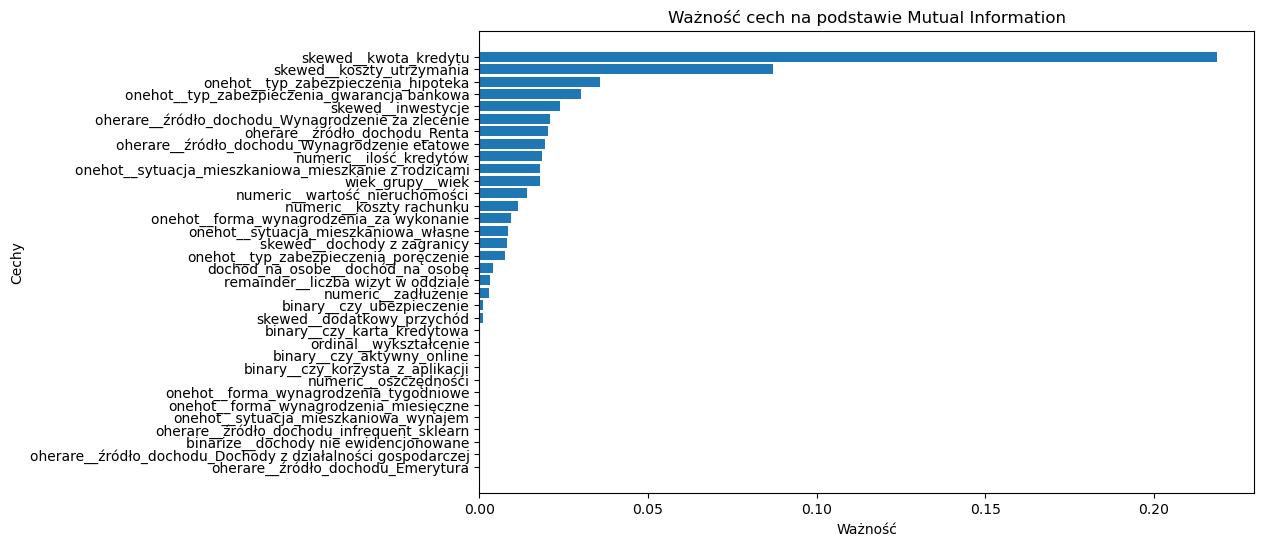

In [49]:




from sklearn.feature_selection import mutual_info_classif, SelectKBest
import pandas as pd

# Obliczenie wartości Mutual Information dla każdej cechy
mi_scores = mutual_info_classif(X_train_transformed, y_train)

# Tworzenie DataFrame z cechami i ich ważnością
mi_importance_df = pd.DataFrame({
    'Feature': X_train_transformed.columns,
    'Importance': mi_scores
}).sort_values(by='Importance', ascending=False)

# Wyświetlenie posortowanego DataFrame
display(mi_importance_df)
# Wizualizacja ważności cech za pomocą wykresu słupkowego#

import matplotlib.pyplot as plt

# Wizualizacja ważności cech za pomocą wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.barh(mi_importance_df['Feature'], mi_importance_df['Importance'])
plt.xlabel('Ważność')
plt.ylabel('Cechy')
plt.title('Ważność cech na podstawie Mutual Information')
plt.gca().invert_yaxis()  # Inwersja osi Y, aby najważniejsze cechy były na górze
plt.show()


#### 5.2. Tworzenie selektora


> Utworzenie selektora na bazie SelectKBest(score_func=mutual_info_classif, k=30)) ])

In [50]:
# Pipeline do selekcji zmiennych metodą mutual information
feature_selection_pipeline_mutual = Pipeline([('selector', SelectKBest(score_func=mutual_info_classif, k=30)) ])




# # Pipeline selekcji cech na podstawie Feature Importance z RF
feature_selection_pipeline_rf = Pipeline([
    ('feature_importance', SelectFromModel(
        RandomForestClassifier(n_estimators=100, random_state=42),
        threshold=-np.inf,                                         # Umożliwia selekcję na podstawie max_features lub threshold='mean'
        max_features=25                                          # Domyślna wartość, zmieniana w siatce hiperparametrów
        ))])


feature_selection_pipeline_xgb = Pipeline([
    ('xgb', SelectFromModel(
        XGBClassifier(n_estimators=100, random_state=42),
        threshold='mean',     # Możemy ustawić próg na 'mean' lub jakąś konkretną wartość
        max_features=25       # Maksymalna liczba cech
    ))
])


from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel

feature_selection_pipeline_dt = Pipeline([
    ('dt', SelectFromModel(
        DecisionTreeClassifier(random_state=42),
        threshold='mean',     # Możemy użyć 'mean' lub ustawić odpowiedni próg
        max_features=25       # Liczba cech do wyboru
    ))
])



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

feature_selection_pipeline_anova = Pipeline([
    ('anova', SelectKBest(f_classif, k=25))  # Wybiera 25 najlepszych cech na podstawie ANOVA F-test
])



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

feature_selection_pipeline_chi2 = Pipeline([
    ('chi2', SelectKBest(chi2, k=25))  # Wybiera 25 najlepszych cech na podstawie testu chi-kwadrat
])



# Każdy z powyższych pipeline'ów implementuje inną metodę selekcji cech:

#     Lasso (L1 regularization) - wykorzystuje regularizację L1, która skutkuje "wygaszaniem" mniej ważnych cech.

#     Chi-squared - stosowane głównie dla zmiennych kategorycznych w celu oceny niezależności cech od klasy.

#     Mutual Information - ocenia, jakie cechy mają największą wzajemną informację z cechą docelową.

#     ANOVA F-test - test statystyczny do oceny różnic wśród grup i wyodrębniania cech.

#     XGBoost - bardziej zaawansowane podejście oparte na gradient boosting, stosowane do oceny cech na podstawie ich znaczenia.

#     Decision Tree - klasyfikator drzewa decyzyjnego, który może być użyty do wybrania najbardziej znaczących cech.

#### 5.3. Tworzenie klasyfikatora

In [51]:

model_pipeline_rf = Pipeline([('classifier', RandomForestClassifier())])      # Tworzenie potoku (pipeline) z klasyfikatorem Random Forest
model_pipeline_lr = Pipeline([('classifier', LogisticRegression())])          # Tworzenie potoku (pipeline) z klasyfikatorem Logistic Regression
model_pipeline_svc = Pipeline([('classifier', SVC())])                        # Tworzenie potoku (pipeline) z klasyfikatorem SVC
model_pipeline_knn = Pipeline([('classifier', KNeighborsClassifier())])       # Tworzenie potoku (pipeline) z klasyfikatorem KNN
model_pipeline_gb = Pipeline([ ('classifier', GradientBoostingClassifier())]) # Tworzenie potoku (pipeline) z klasyfikatorem Gradient Boosting

# Tworzenie DataFrame opisującego proces tworzenia klasyfikatora
classifier_creation_process = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'SVC', 'KNN', 'Gradient Boosting'],
    'Pipeline Steps': [
        'Pipeline([("classifier", RandomForestClassifier())])',
        'Pipeline([("classifier", LogisticRegression())])',
        'Pipeline([("classifier", SVC())])',
        'Pipeline([("classifier", KNeighborsClassifier())])',
        'Pipeline([("classifier", GradientBoostingClassifier())])'
    ],
    'Description': [
        'Tworzenie potoku z klasyfikatorem Random Forest',
        'Tworzenie potoku z klasyfikatorem Logistic Regression',
        'Tworzenie potoku z klasyfikatorem SVC',
        'Tworzenie potoku z klasyfikatorem KNN',
        'Tworzenie potoku z klasyfikatorem Gradient Boosting'
    ]
})

# Wyświetlenie DataFrame
display(classifier_creation_process)

Model  \
0        Random Forest   
1  Logistic Regression   
2                  SVC   
3                  KNN   
4    Gradient Boosting   

                                             Pipeline Steps  \
0      Pipeline([("classifier", RandomForestClassifier())])   
1          Pipeline([("classifier", LogisticRegression())])   
2                         Pipeline([("classifier", SVC())])   
3        Pipeline([("classifier", KNeighborsClassifier())])   
4  Pipeline([("classifier", GradientBoostingClassifier())])   

                                             Description  
0        Tworzenie potoku z klasyfikatorem Random Forest  
1  Tworzenie potoku z klasyfikatorem Logistic Regression  
2                  Tworzenie potoku z klasyfikatorem SVC  
3                  Tworzenie potoku z klasyfikatorem KNN  
4    Tworzenie potoku z klasyfikatorem Gradient Boosting

#### 5.4. Ostateczny przepływ

In [55]:
model_rf = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych
    ('classifier', model_pipeline_rf)                                 # Model klasyfikacyjny
])


model_lr = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych
    ('classifier', model_pipeline_lr)                              # Model klasyfikacyjny
])


model_svc = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych
    ('classifier', model_pipeline_svc)                             # Model klasyfikacyjny
])


model_knn = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych
    ('classifier', model_pipeline_knn)                             # Model klasyfikacyjny
])


model_gb = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych
    ('classifier', model_pipeline_gb)                              # Model klasyfikacyjny
])


model_dt = Pipeline([
    ('preprocessor', preprocessor),                               # Preprocessing
    ('feature_selection', feature_selection_pipeline_mutual),     # Selekcja zmiennych (np. na podstawie mutual information)
    ('classifier', DecisionTreeClassifier(random_state=42))       # Model klasyfikacyjny: DecisionTreeClassifier
])



# Tworzenie DataFrame z informacjami o preprocesorze, selektorze i klasyfikatorze
pipeline_summary = pd.DataFrame({
    'Preprocesor': ['preprocessor'] * 6,
    'Selektor': [
        'feature_selection_pipeline_mutual',
        'feature_selection_pipeline_mutual',
        'feature_selection_pipeline_mutual',
        'feature_selection_pipeline_mutual',
        'feature_selection_pipeline_mutual',
        'feature_selection_pipeline_mutual'
    ],
    'Klasyfikator': [
        'model_pipeline_rf',
        'model_pipeline_lr',
        'model_pipeline_svc',
        'model_pipeline_knn',
        'model_pipeline_gb',
        'DecisionTreeClassifier'
    ]
})
pipeline_summary['Nazwa modelu'] = ['Random Forest', 'Logistic Regression', 'SVC', 'KNN', 'Gradient Boosting', 'Decision Tree']
# Wyświetlenie DataFrame
display(Markdown('**Podsumowanie pipeline\'ów:**'))
display(pipeline_summary)



**Podsumowanie pipeline'ów:**

Preprocesor                           Selektor            Klasyfikator  \
0  preprocessor  feature_selection_pipeline_mutual       model_pipeline_rf   
1  preprocessor  feature_selection_pipeline_mutual       model_pipeline_lr   
2  preprocessor  feature_selection_pipeline_mutual      model_pipeline_svc   
3  preprocessor  feature_selection_pipeline_mutual      model_pipeline_knn   
4  preprocessor  feature_selection_pipeline_mutual       model_pipeline_gb   
5  preprocessor  feature_selection_pipeline_mutual  DecisionTreeClassifier   

          Nazwa modelu  
0        Random Forest  
1  Logistic Regression  
2                  SVC  
3                  KNN  
4    Gradient Boosting  
5        Decision Tree

### 5. Definiowanie walidacji krzyżowej

> Parametry:
- StratifiedKFold – technika walidacji krzyżowej, która zachowuje proporcje klas w każdym foldzie (przydatne w problemach z niezbalansowanymi danymi).
- n_splits=10 – podział zbioru na 10 równych części (foldów), gdzie 9 części jest używanych do trenowania, a 1 do testowania w każdej - shuffle=True – losowe przetasowanie danych przed podziałem, aby uniknąć zależności w kolejności obserwacji.
- andom_state=42 – ustawienie losowego ziarna w celu zapewnienia powtarzalności wyników.

To ustawienie sprawia, że model będzie testowany na różnych częściach danych, ale proporcje klas w każdym foldzie pozostaną zachowane. 

In [56]:
pd.set_option('display.max_colwidth', None)


# ==================================================================== 
# Definiowanie walidacji krzyżowej
# ====================================================================

cv_def = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold



### 6. Ewaluacja modelu wg CV dla różnych modeli klasyfikacyjnych na ustawieniach domyślnych

### celem jest:

- Ocena modeli klasyfikacyjnych: Użycie walidacji krzyżowej do uzyskania wiarygodnych metryk wydajności (dokładności i F1-score) dla różnych modeli.
- Wizualizacja wyników: Przedstawienie graficzne dokładności modelu w poszczególnych iteracjach walidacji krzyżowej, wraz z informacjami o średniej wydajności i odchyleniu standardowym.
- Porównanie modeli: Umożliwienie wizualnego porównania wydajności różnych modeli klasyfikacyjnych na tych samych danych treningowych i przy użyciu tej samej strategii walidacji krzyżowej.
- Analiza stabilności modelu: Zobaczenie, jak bardzo zmienia się dokładność modelu w różnych foldach walidacji krzyżowej, co daje wgląd w stabilność jego działania.

Model: Random Forest


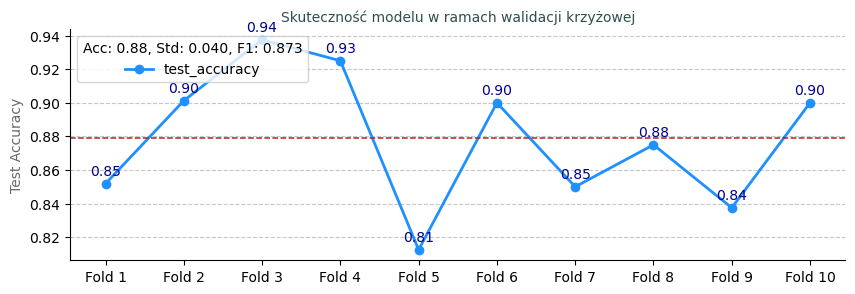

Model: K-Nearest Neighbors


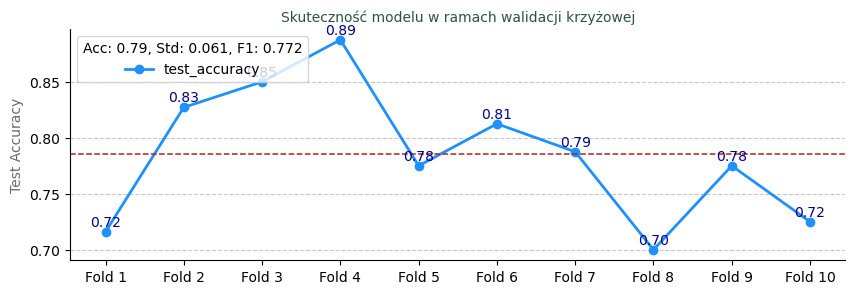

Model: Decision Tree


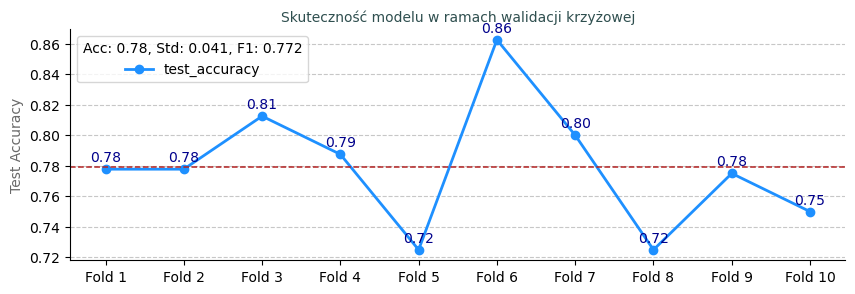

Model: Support Vector Classifier


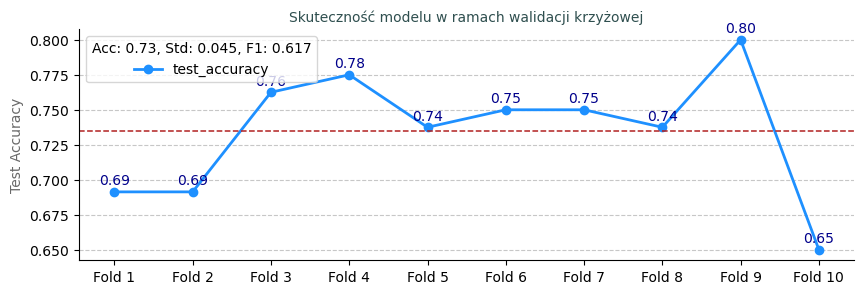

Model: Logistic Regression


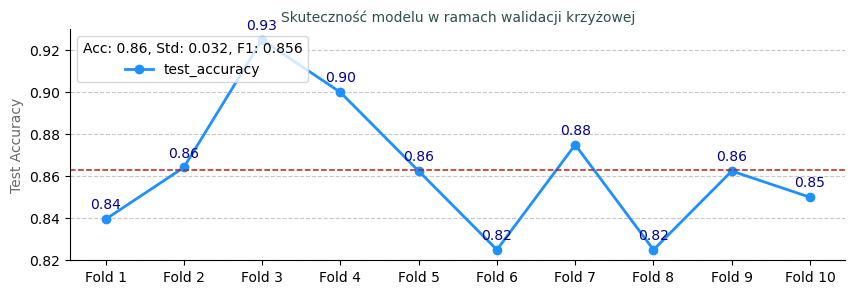

Model: Gradient Boosting


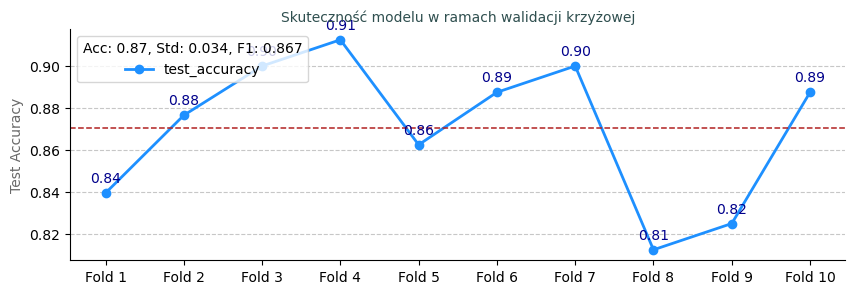

In [57]:

# # ====================================================================
# # Ewaluacja modelu wg CV dla różnych modeli klasyfikacyjnych na ustawieniach domyślnych
# # ====================================================================



import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_validate

def evaluate_model_cv(model, X_train, y_train, cv):
    # Cross-validation
    cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring={'accuracy': 'accuracy', 'f1': 'f1'})
    score_train = pd.DataFrame(cv_results)
    mean_accuracy = score_train["test_accuracy"].mean()
    std_accuracy = score_train["test_accuracy"].std()
    mean_f1 = score_train["test_f1"].mean()
    plt.figure(figsize=(10, 3))
    score_train["test_accuracy"].plot(kind='line', marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=6,
                                       title='Skuteczność modelu danych testowych',
                                       xlabel='', ylabel='Test Accuracy')
    plt.axhline(y=mean_accuracy, color='firebrick', linestyle='--', linewidth=1.1)
    plt.grid(axis='y', linestyle='--', linewidth=0.8, alpha=0.7)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.legend(title=f'Acc: {mean_accuracy:.2f}, Std: {std_accuracy:.3f}, F1: {mean_f1:.3f}', loc='upper left')
    for i, v in enumerate(score_train["test_accuracy"]):
        plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=10, color='darkblue')
    plt.xticks(ticks=range(len(score_train)), labels=[f'Fold {i+1}' for i in range(len(score_train))])
    plt.title('Skuteczność modelu w ramach walidacji krzyżowej', fontsize=10, color='darkslategray')
    plt.ylabel('Test Accuracy', fontsize=10, color='dimgray')
    plt.show()
    return



print("Model: Random Forest")
evaluate_model_cv(model_rf, X_train, y_train, cv_def)

print("Model: K-Nearest Neighbors")
evaluate_model_cv(model_knn, X_train, y_train, cv_def)

print("Model: Decision Tree")
evaluate_model_cv(model_dt, X_train, y_train, cv_def)

print("Model: Support Vector Classifier")
evaluate_model_cv(model_svc, X_train, y_train, cv_def)

print("Model: Logistic Regression")
evaluate_model_cv(model_lr, X_train, y_train, cv_def)

print("Model: Gradient Boosting")
evaluate_model_cv(model_gb, X_train, y_train, cv_def)






#### 6.2.Ocena wydajności modelu uczenia maszynowego w zależności od wartości hiperparametru.

In [58]:
#====================================================================================
# Ocena wydajności modelu uczenia maszynowego w zależności od wartości hiperparametru.
#====================================================================================
def plot_validation_curve(estimator, X, y, param_name, param_range, scoring='accuracy', cv=5, use_log_scale=False):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import validation_curve
    
    if hasattr(estimator, 'steps'):
        model_name = type(estimator.steps[-1][1]).__name__  # Pobranie nazwy modelu z pipeline
    else:
        model_name = type(estimator).__name__  # Pobranie nazwy modelu
    
    # Obliczanie wyników walidacji
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, scoring=scoring, cv=cv)
    
    # Obliczanie średnich i odchyleń standardowych
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # Obliczanie błędów
    train_error = 1 - train_scores
    test_error = 1 - test_scores
    train_error_mean = np.mean(train_error, axis=1)
    test_error_mean = np.mean(test_error, axis=1)
    
    # Konfiguracja wykresów
    plt.figure(figsize=(20, 4))
    
    # Subplot 1: Dokładność
    plt.subplot(1, 2, 1)
    plt.plot(param_range, train_mean, label="Dokładność treningowa", color="blue", marker="o", linewidth=2)
    plt.plot(param_range, test_mean, label="Dokładność walidacyjna", color="orange", marker="o", linewidth=2)
    plt.title(f"Krzywa Walidacyjna")
    plt.ylabel(f"{scoring.capitalize()}")
    plt.xlabel(f"{param_name}")
    plt.legend(loc="best")
    plt.grid(True)
    if use_log_scale:
        plt.xscale('log')
    else:
        plt.xticks(param_range)
    
    # Subplot 2: Błąd
    plt.subplot(1, 2, 2)
    plt.plot(param_range, train_error_mean, label="Błąd treningowy", color="red", marker="s", linewidth=2)
    plt.plot(param_range, test_error_mean, label="Błąd walidacyjny", color="green", marker="s", linewidth=2)
    plt.title(f"Krzywa Błędu ({model_name}, {param_name})")
    plt.ylabel("Error Rate")
    plt.xlabel(f"{param_name}")
    plt.legend(loc="best")
    plt.grid(True)
    if use_log_scale:
        plt.xscale('log')
    else:
        plt.xticks(param_range)
    
    plt.tight_layout()
    plt.show()



def create_validation_table(estimator, X, y, param_name, param_range, scoring='accuracy', cv=5):

    # Obliczanie wyników walidacji
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range, 
        scoring=scoring, cv=cv)
        # Obliczanie średnich
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    # Obliczanie błędów
    train_error = 1 - train_mean
    test_error = 1 - test_mean
    
    # Obliczanie różnicy błędów (różnica między błędem testowym a treningowym)
    error_diff = test_error - train_error
    
    # Tworzenie tabeli wyników
    results = pd.DataFrame({
        param_name: param_range,
        'Train Accuracy': train_mean,
        'Validation Accuracy': test_mean,
        'Train Error': train_error,
        'Validation Error': test_error,
        'Error Difference': error_diff
    })
    
    # Formatowanie wartości liczbowych (opcjonalnie)
    float_cols = ['Train Accuracy', 'Validation Accuracy', 'Train Error', 'Validation Error', 'Error Difference']
    results[float_cols] = results[float_cols].applymap(lambda x: f"{x:.4f}")
    
    return









Ocena modelu KNN - Validation Curve


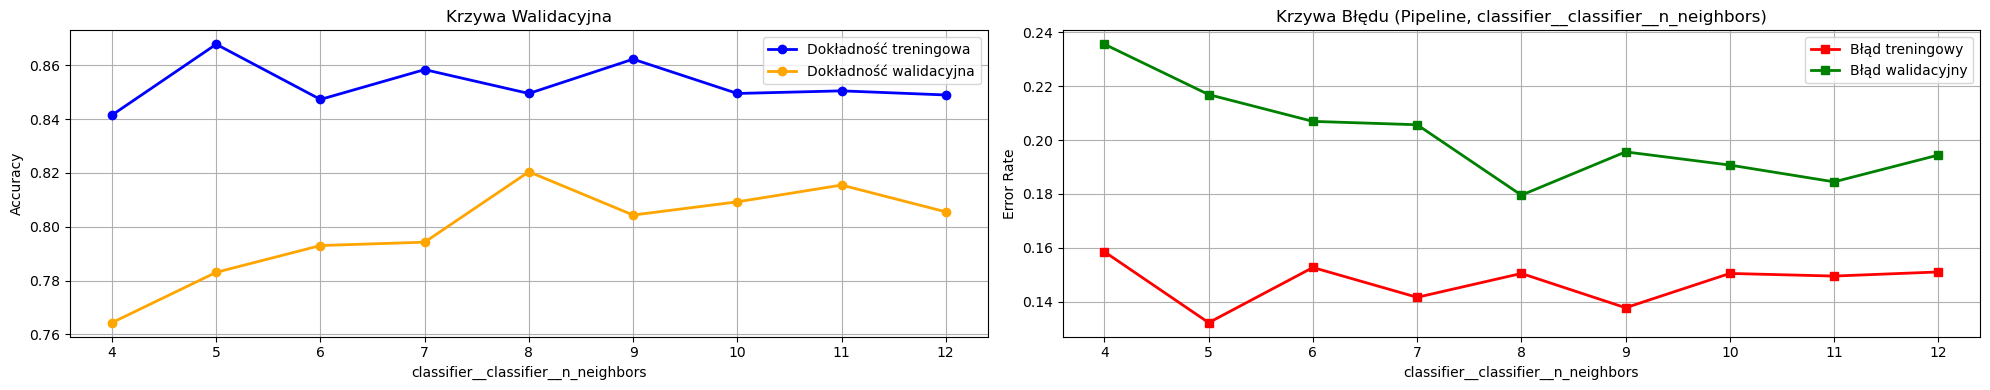

Ocena modelu Random Forest - Validation Curve


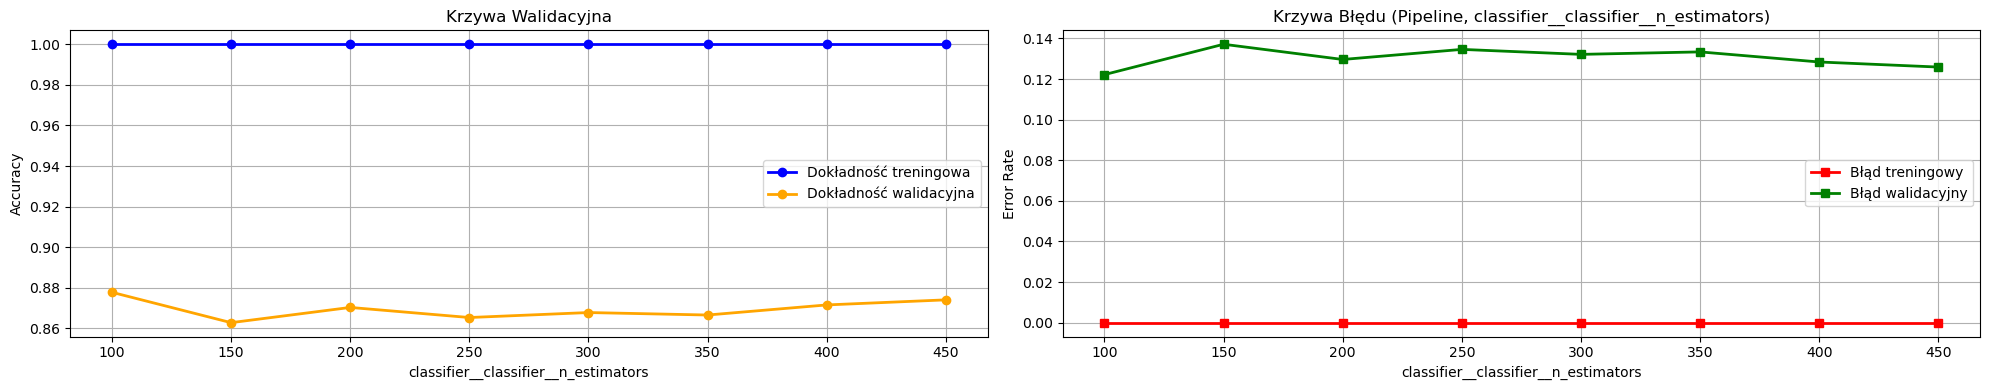

Ocena modelu Logistic Regression - Validation Curve


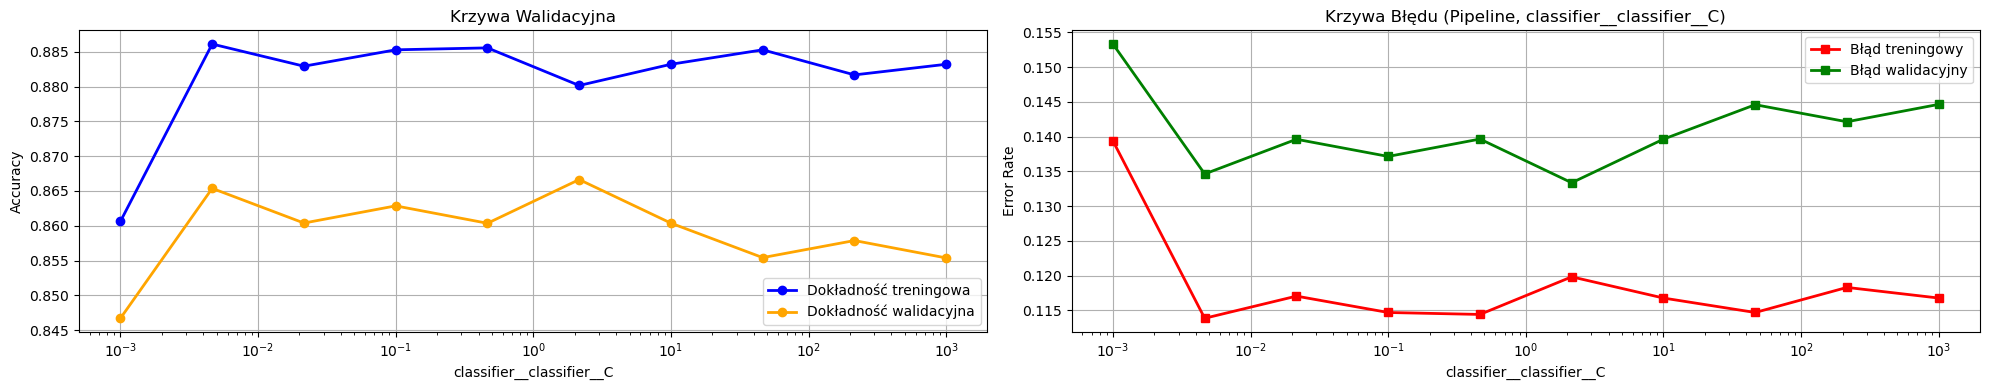

Ocena modelu SVC - Validation Curve


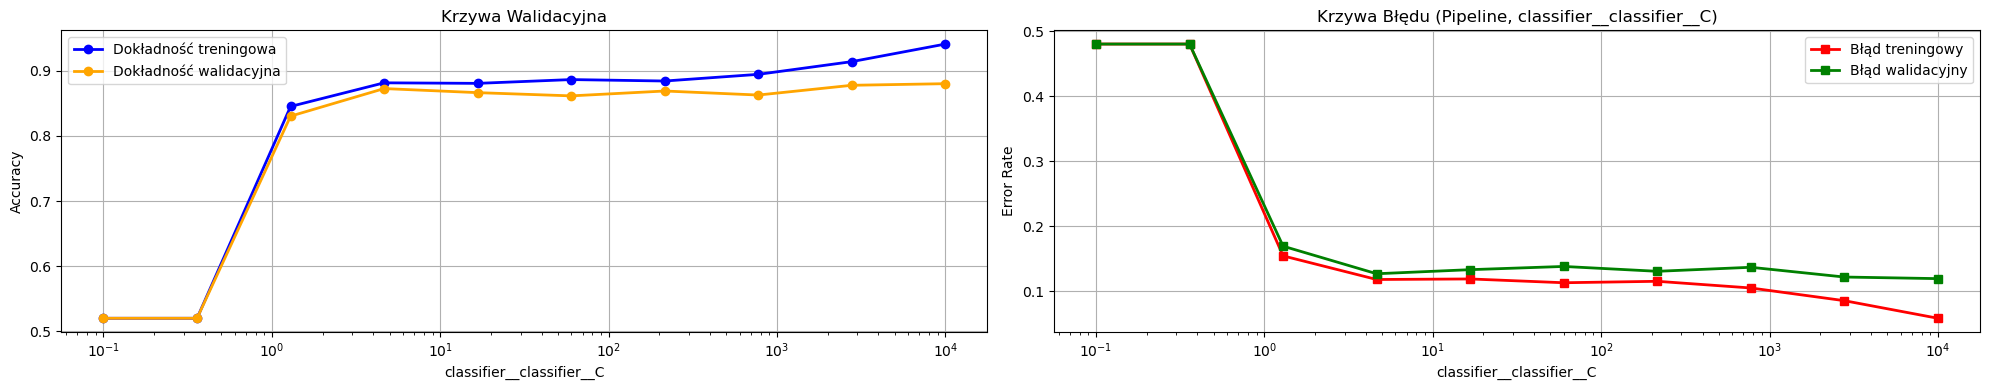

Ocena modelu Gradient Boosting - Validation Curve


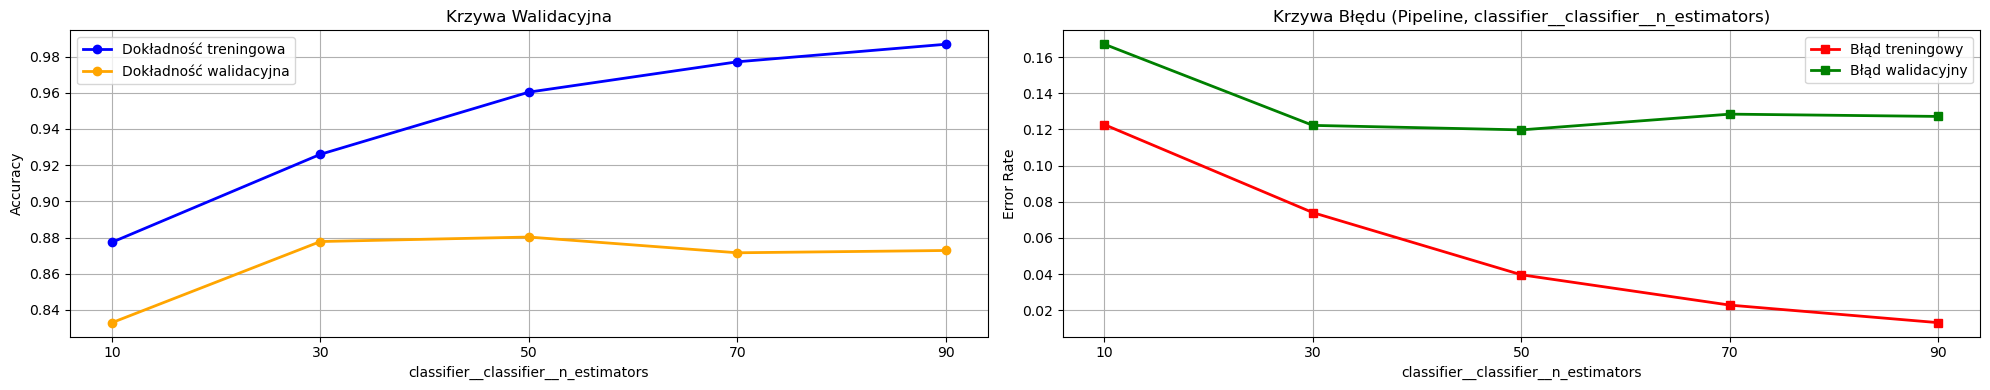

In [59]:
print("Ocena modelu KNN - Validation Curve")
plot_validation_curve(
    estimator=model_knn,
    X=X_train,
    y=y_train,
    param_name='classifier__classifier__n_neighbors',
    param_range=range(4, 13),  
    scoring='accuracy',
    cv=cv_def
)

print("Ocena modelu Random Forest - Validation Curve")
plot_validation_curve(
    estimator=model_rf,
    X=X_train,
    y=y_train,
    param_name='classifier__classifier__n_estimators',
    param_range=range(100, 500, 50),  
    scoring='accuracy',
    cv=cv_def
)

print("Ocena modelu Logistic Regression - Validation Curve")
plot_validation_curve(
    estimator=model_lr,
    X=X_train,
    y=y_train,
    param_name='classifier__classifier__C',
    param_range=np.logspace(-3, 3, 10),  
    scoring='accuracy',
    cv=cv_def,
    use_log_scale=True
)

print("Ocena modelu SVC - Validation Curve")
plot_validation_curve(
    estimator=model_svc,
    X=X_train,
    y=y_train,
    param_name='classifier__classifier__C',
    param_range=np.logspace(-1, 4, 10),  
    scoring='accuracy',
    cv=cv_def,
    use_log_scale=True
)

print("Ocena modelu Gradient Boosting - Validation Curve")
plot_validation_curve(
    estimator=model_gb,
    X=X_train,
    y=y_train,
    param_name='classifier__classifier__n_estimators',
    param_range=range(10, 100, 20),  
    scoring='accuracy',
    cv=cv_def
)


### 7.Strojenie hiperparametrów

#### 7.1. Definicja parametrów siatki

In [60]:
# ====================================================================
# Definicja siatki parametrów
# ====================================================================


param_grid = {
    # Parametry preprocessora
    'preprocessor__numeric__simpleimputer__strategy': ['mean', 'median'],
    'preprocessor__numeric__standardscaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
    'preprocessor__skewed__simpleimputer__strategy': ['mean', 'median'],
    'preprocessor__skewed__powertransformer': [
                                                PowerTransformer(method='yeo-johnson', standardize=True),
                                                PowerTransformer(method='box-cox', standardize=True)],
    'feature_selection__selector__k': [20,21,22,23,24,25,26,27,28,29,30,31,33],

    # Parametry RandomForestClassifier
     'classifier__classifier__n_estimators': [50, 100, 200],      
    'classifier__classifier__max_depth': [None, 10, 20, 30],      
    'classifier__classifier__min_samples_split': [2, 5, 10],      
    'classifier__classifier__min_samples_leaf': [1, 2, 4],        
    'classifier__classifier__max_features': ['auto', 'sqrt', 'log2'],  
    'classifier__classifier__bootstrap': [True, False],            
    'classifier__classifier__class_weight': [None, 'balanced'],    
}


# Tworzenie DataFrame z elementami parametrów siatki
param_grid_df = pd.DataFrame([
    {'Kategoria': 'Preprocessor', 'Parametr': 'preprocessor__numeric__simpleimputer__strategy', 'Wartości': ['mean', 'median']},
    {'Kategoria': 'Preprocessor', 'Parametr': 'preprocessor__numeric__standardscaler', 'Wartości': ['StandardScaler', 'MinMaxScaler', 'RobustScaler']},
    {'Kategoria': 'Preprocessor', 'Parametr': 'preprocessor__skewed__simpleimputer__strategy', 'Wartości': ['mean', 'median']},
    {'Kategoria': 'Preprocessor', 'Parametr': 'preprocessor__skewed__powertransformer', 'Wartości': ['PowerTransformer(yeo-johnson)', 'PowerTransformer(box-cox)']},
    {'Kategoria': 'Feature Selection', 'Parametr': 'feature_selection__selector__k', 'Wartości': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__n_estimators', 'Wartości': [50, 100, 200]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__max_depth', 'Wartości': [None, 10, 20, 30]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__min_samples_split', 'Wartości': [2, 5, 10]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__min_samples_leaf', 'Wartości': [1, 2, 4]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__max_features', 'Wartości': ['auto', 'sqrt', 'log2']},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__bootstrap', 'Wartości': [True, False]},
    {'Kategoria': 'Classifier', 'Parametr': 'classifier__classifier__class_weight', 'Wartości': [None, 'balanced']}
])

# Wyświetlenie tabeli
display(param_grid_df)


Kategoria                                        Parametr  \
0        Preprocessor  preprocessor__numeric__simpleimputer__strategy   
1        Preprocessor           preprocessor__numeric__standardscaler   
2        Preprocessor   preprocessor__skewed__simpleimputer__strategy   
3        Preprocessor          preprocessor__skewed__powertransformer   
4   Feature Selection                  feature_selection__selector__k   
5          Classifier            classifier__classifier__n_estimators   
6          Classifier               classifier__classifier__max_depth   
7          Classifier       classifier__classifier__min_samples_split   
8          Classifier        classifier__classifier__min_samples_leaf   
9          Classifier            classifier__classifier__max_features   
10         Classifier               classifier__classifier__bootstrap   
11         Classifier            classifier__classifier__class_weight   

                                                      Wartości  
0                                               [mean, median]  
1                 [StandardScaler, MinMaxScaler, RobustScaler]  
2                                               [mean, median]  
3   [PowerTransformer(yeo-johnson), PowerTransformer(box-cox)]  
4         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33]  
5                                               [50, 100, 200]  
6                                           [None, 10, 20, 30]  
7                                                   [2, 5, 10]  
8                                                    [1, 2, 4]  
9                                           [auto, sqrt, log2]  
10                                               [True, False]  
11                                            [None, balanced]

#### 7.2.Defniowanie miar oceny

In [61]:


scoring_gs = {
   "AUC": "roc_auc",
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score),
    "Recall": make_scorer(recall_score),
    "F1-score": make_scorer(f1_score),
    "AUC-PR": make_scorer(average_precision_score)
}


import pandas as pd

# Definicja tabeli z opisem metryk
metrics_info = {
    "Nazwa": ["AUC", "Accuracy", "Precision", "Recall", "F1-score", "AUC-PR"],
    "Pełna nazwa": [
        "Area Under the ROC Curve",
        "Accuracy",
        "Precision",
        "Recall (Sensitivity)",
        "F1-score",
        "Average Precision Score (AUC-PR)"
    ],
    "Opis": [
        "Pole pod krzywą ROC, mierzy zdolność modelu do rozróżniania klas.",
        "Odsetek poprawnie sklasyfikowanych obserwacji.",
        "Odsetek prawidłowo przewidzianych pozytywnych przypadków wśród wszystkich przewidzianych jako pozytywne.",
        "Odsetek prawidłowo przewidzianych pozytywnych przypadków wśród wszystkich rzeczywiście pozytywnych.",
        "Średnia harmoniczna Precision i Recall. Dobry kompromis między nimi.",
        "Pole pod krzywą Precision-Recall, szczególnie użyteczne dla niezbalansowanych klas."
    ]
}

df_metrics = pd.DataFrame(metrics_info)

display(df_metrics)




Nazwa                       Pełna nazwa  \
0        AUC          Area Under the ROC Curve   
1   Accuracy                          Accuracy   
2  Precision                         Precision   
3     Recall              Recall (Sensitivity)   
4   F1-score                          F1-score   
5     AUC-PR  Average Precision Score (AUC-PR)   

                                                                                                       Opis  
0                                         Pole pod krzywą ROC, mierzy zdolność modelu do rozróżniania klas.  
1                                                            Odsetek poprawnie sklasyfikowanych obserwacji.  
2  Odsetek prawidłowo przewidzianych pozytywnych przypadków wśród wszystkich przewidzianych jako pozytywne.  
3       Odsetek prawidłowo przewidzianych pozytywnych przypadków wśród wszystkich rzeczywiście pozytywnych.  
4                                      Średnia harmoniczna Precision i Recall. Dobry kompromis między nimi.  
5                       Pole pod krzywą Precision-Recall, szczególnie użyteczne dla niezbalansowanych klas.

#### 7.3.Przeszukiwanie hiperparametrów

In [62]:
print("Tabela parametrów RandomizedSearchCV: ")

import pandas as pd

# Dane do tabeli
random_search_info = {
    "Parametr": [
        "estimator",
        "param_distributions",
        "cv",
        "scoring",
        "n_jobs",
        "return_train_score",
        "refit",
        "n_iter",
        "random_state"
    ],
    "Wartość": [
        "model_rf",
        "param_grid",
        "cv_def",
        "scoring_gs",
        "-1",
        "True",
        "'Accuracy'",
        "100",
        "42"
    ],
    "Opis": [
        "Model poddawany optymalizacji (Random Forest w pipeline).",
        "Rozkład wartości hiperparametrów do losowania.",
        "Strategia walidacji krzyżowej.",
        "Słownik metryk oceny modelu.",
        "Liczba równoległych procesów (-1 oznacza wszystkie dostępne rdzenie CPU).",
        "Czy zapisywać wyniki na zbiorze treningowym.",
        "Metryka, według której zostanie wybrany najlepszy model.",
        "Liczba losowych kombinacji hiperparametrów do przetestowania.",
        "Seed generatora liczb losowych dla powtarzalności wyników."
    ]
}

# Tworzenie DataFrame
df_random_search = pd.DataFrame(random_search_info)

# Wyświetlenie tabeli
pd.set_option('display.max_colwidth', None)
display(df_random_search)


Tabela parametrów RandomizedSearchCV: 


Parametr     Wartość  \
0            estimator    model_rf   
1  param_distributions  param_grid   
2                   cv      cv_def   
3              scoring  scoring_gs   
4               n_jobs          -1   
5   return_train_score        True   
6                refit  'Accuracy'   
7               n_iter         100   
8         random_state          42   

                                                                        Opis  
0                  Model poddawany optymalizacji (Random Forest w pipeline).  
1                             Rozkład wartości hiperparametrów do losowania.  
2                                             Strategia walidacji krzyżowej.  
3                                               Słownik metryk oceny modelu.  
4  Liczba równoległych procesów (-1 oznacza wszystkie dostępne rdzenie CPU).  
5                               Czy zapisywać wyniki na zbiorze treningowym.  
6                   Metryka, według której zostanie wybrany najlepszy model.  
7              Liczba losowych kombinacji hiperparametrów do przetestowania.  
8                 Seed generatora liczb losowych dla powtarzalności wyników.

#### 7.4. Proces uczenia modelu na danych treningowych (X_train, y_train)

> **random_search.fit(X_train, y_train)** 

> Wywołanie metody fit obiektu RandomizedSearchCV (lub podobnego, np. GridSearchCV), gdzie:
- random_search: To instancja klasy, która implementuje losowe przeszukiwanie hiperparametrów (Randomized Search).
- X_train: To zbiór danych treningowych (cechy), na którym model będzie trenowany i walidowany w procesie poszukiwania najlepszych hiperparametrów.
- y_train: To etykiety odpowiadające danym treningowym, używane do oceny wydajności modelu dla różnych kombinacji hiperparametrów.


In [63]:
import pandas as pd

# Przygotowanie danych do tabeli
data = {
    "Etap": [
        "Losowanie kombinacji hiperparametrów",
        "Walidacja krzyżowa",
        "Ewaluacja metryk",
        "Zapis wyników",
        "Wybór najlepszego modelu",
        "Dostęp do najlepszych wyników"
    ],
    "Opis": [
        "Losuje 100 różnych zestawów hiperparametrów z podanego rozkładu param_grid.",
        "Dla każdej kombinacji wykonuje walidację krzyżową zgodnie z obiektem cv_def.",
        "Dla każdego podziału danych obliczane są metryki ze słownika scoring_gs: Accuracy, AUC, Precision, Recall, F1-score, AUC-PR.",
        "Wyniki walidacji zapisywane są w atrybucie .cv_results_. Dzięki return_train_score=True zapisywane są również wyniki na zbiorze treningowym.",
        "Na podstawie metryki Accuracy (parametr refit='Accuracy') wybierany jest najlepszy zestaw hiperparametrów. Model z tymi parametrami jest trenowany na pełnym zbiorze treningowym.",
        "Po zakończeniu procesu dostępne są: best_params_ (najlepsze hiperparametry), best_score_ (najlepszy wynik Accuracy), best_estimator_ (najlepszy model)."
    ]
}

# Utworzenie DataFrame
df_explanation = pd.DataFrame(data)

# Wyświetlenie tabeli
pd.set_option('display.max_colwidth', None)
display(df_explanation)


Etap  \
0  Losowanie kombinacji hiperparametrów   
1                    Walidacja krzyżowa   
2                      Ewaluacja metryk   
3                         Zapis wyników   
4              Wybór najlepszego modelu   
5         Dostęp do najlepszych wyników   

                                                                                                                                                                                Opis  
0                                                                                                        Losuje 100 różnych zestawów hiperparametrów z podanego rozkładu param_grid.  
1                                                                                                       Dla każdej kombinacji wykonuje walidację krzyżową zgodnie z obiektem cv_def.  
2                                                       Dla każdego podziału danych obliczane są metryki ze słownika scoring_gs: Accuracy, AUC, Precision, Recall, F1-score, AUC-PR.  
3                                       Wyniki walidacji zapisywane są w atrybucie .cv_results_. Dzięki return_train_score=True zapisywane są również wyniki na zbiorze treningowym.  
4  Na podstawie metryki Accuracy (parametr refit='Accuracy') wybierany jest najlepszy zestaw hiperparametrów. Model z tymi parametrami jest trenowany na pełnym zbiorze treningowym.  
5                            Po zakończeniu procesu dostępne są: best_params_ (najlepsze hiperparametry), best_score_ (najlepszy wynik Accuracy), best_estimator_ (najlepszy model).

In [65]:


# # ====================================================================
# # Przeszukiwanie hiperparametrów
# # ====================================================================


random_search = RandomizedSearchCV(
    model_rf,
    param_distributions=param_grid, 
    cv=cv_def,
    scoring=scoring_gs,
    n_jobs=-1,
    return_train_score=True,
    refit="Accuracy",
    n_iter=100,  
    random_state=42  
)

random_search.fit(X_train, y_train)






/tmp/ipykernel_4543/98414040.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


/tmp/ipykernel_4543/98414040.py:41: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[c

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ordinalencoder',
                                                                                                OrdinalEncoder()),
                                                                                               ('binarizer',
                                                                                                Binarizer(threshold=0.5))]),
                                                                               ['czy_karta...
                   scoring={'AUC': 'roc_auc',
                            'AUC-PR': make_scorer(average_precision_score, response_method='predict'),
                            'Accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'F1-score': make_scorer(f1_score, response_method='predict'),
                            'Precision': make_scorer(precision_score, response_method='predict'),
                            'Recall': make_scorer(recall_score, response_method='predict')})

### 8. Wybranie optymalnych hiperparametrów dla modelu

In [80]:

# Wyświetlenie najlepszego modelu i jego parametrów
best_model = random_search.best_estimator_
best_params = random_search.best_params_
best_score = random_search.best_score_

cv_results = random_search.cv_results_
results_df = pd.DataFrame(cv_results)

# Wybierz tylko kolumny z średnimi testowymi miarami
mean_test_measures = [col for col in results_df.columns if col.startswith('mean_test_')]

# Dodaj kolumnę params, aby mieć informacje o parametrach
selected_cols = ['params'] + mean_test_measures

# Wyświetl DataFrame z wybranymi kolumnami, posortowany według rankingu (jeśli istnieje)
print("\nŚrednie testowe miary:")
try:
    display(results_df[selected_cols].sort_values(by= [col for col in results_df.columns if col.startswith('mean_test__')][0]))
except IndexError:
    display(results_df[selected_cols].head(1).T)


Średnie testowe miary:


0
params               {'preprocessor__skewed__simpleimputer__strategy': 'mean', 'preprocessor__skewed__powertransformer': PowerTransformer(method='box-cox'), 'preprocessor__numeric__standardscaler': StandardScaler(), 'preprocessor__numeric__simpleimputer__strategy': 'median', 'feature_selection__selector__k': 31, 'classifier__classifier__n_estimators': 50, 'classifier__classifier__min_samples_split': 5, 'classifier__classifier__min_samples_leaf': 2, 'classifier__classifier__max_features': 'log2', 'classifier__classifier__max_depth': None, 'classifier__classifier__class_weight': 'balanced', 'classifier__classifier__bootstrap': True}
mean_test_AUC                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         0.934082
mean_test_Accuracy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    0.861636
mean_test_Precision                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   0.862312
mean_test_Recall                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      0.851889
mean_test_F1-score                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    0.855769
mean_test_AUC-PR                                                                                                                                                    

#### 8.1. Wybranie modelu i jego hiperparametrów

In [97]:
print("Najlepszy klasyfikator:")
print(RandomForestClassifier())

Najlepszy klasyfikator:
RandomForestClassifier()


In [91]:
print("Najlepsze parametry")
best_params

Najlepsze parametry


{'preprocessor__skewed__simpleimputer__strategy': 'median',
 'preprocessor__skewed__powertransformer': PowerTransformer(),
 'preprocessor__numeric__standardscaler': StandardScaler(),
 'preprocessor__numeric__simpleimputer__strategy': 'median',
 'feature_selection__selector__k': 29,
 'classifier__classifier__n_estimators': 100,
 'classifier__classifier__min_samples_split': 2,
 'classifier__classifier__min_samples_leaf': 2,
 'classifier__classifier__max_features': 'log2',
 'classifier__classifier__max_depth': 20,
 'classifier__classifier__class_weight': 'balanced',
 'classifier__classifier__bootstrap': True}

In [98]:
print("Najlepsza miara skuteczności na zbiorze treningowym:")
round(best_score,4)

Najlepsza miara skuteczności na zbiorze treningowym:


0.8815

### 9. Predykcja  i ocena modelu na danych testowych

In [114]:

# # ====================================================================
# # Predykcja  i ocena modelu na danych testowych
# # ====================================================================



# Predykcje modelu
y_pred_test = best_model.predict(X_test)
y_prob_test = best_model.predict_proba(X_test)[:, 1]  # prawdopodobieństwa dla klasy pozytywnej

# Obliczenie macierzy konfuzji
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()

# Obliczenie dodatkowych metryk
accuracy_test = accuracy_score(y_test, y_pred_test)
error_ratio = (fp + fn) / (tp + fp + fn + tn)  # stosunek błędów do wszystkich predykcji
precision_pos = precision_score(y_test, y_pred_test, pos_label=1)
precision_neg = precision_score(y_test, y_pred_test, pos_label=0)
recall_pos = recall_score(y_test, y_pred_test, pos_label=1)
recall_neg = recall_score(y_test, y_pred_test, pos_label=0)
f1_test = f1_score(y_test, y_pred_test)
roc_auc_test = roc_auc_score(y_test, y_prob_test)
cohen_kappa = cohen_kappa_score(y_test, y_pred_test)
matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred_test)

# # Wyświetlenie wyników
# print("Wyniki na danych testowych:")
# print(f"TP (True Positives): {tp}")
# print(f"FP (False Positives): {fp}")
# print(f"FN (False Negatives): {fn}")
# print(f"TN (True Negatives): {tn}")
# print(f"Accuracy: {accuracy_test:.4f}")
# print(f"Error Ratio: {error_ratio:.4f}")
# print(f"Precision (Positive Class): {precision_pos:.4f}")
# print(f"Precision (Negative Class): {precision_neg:.4f}")
# print(f"Recall (Positive Class): {recall_pos:.4f}")
# print(f"Recall (Negative Class): {recall_neg:.4f}")
# print(f"F1-score: {f1_test:.4f}")
# print(f"ROC AUC: {roc_auc_test:.4f}")
# print(f"Cohen's Kappa: {cohen_kappa:.4f}")
# print(f"Matthews Correlation Coefficient: {matthews_corrcoef_score:.4f}")

# Tworzenie słownika z wynikami


# ... (Twój wcześniejszy kod, który oblicza tp, fp, fn, tn, accuracy_test, error_ratio, etc.) ...

results = {
    "Metryka": ["TP", "FP", "FN", "TN", "Accuracy", "Error Ratio", "Precision (Positive)",
               "Precision (Negative)", "Recall (Positive)", "Recall (Negative)", "F1-score",
               "ROC AUC", "Cohen's Kappa", "Matthews Correlation Coefficient"],
    "Wartość": [tp, fp, fn, tn, accuracy_test, error_ratio, precision_pos,
              precision_neg, recall_pos, recall_neg, f1_test,
              roc_auc_test, cohen_kappa, matthews_corrcoef_score],
    "Definicja": [
        "True Positives: Liczba poprawnie przewidzianych pozytywnych przypadków.",
        "False Positives: Liczba błędnie przewidzianych pozytywnych przypadków (błędy typu I).",
        "False Negatives: Liczba błędnie przewidzianych negatywnych przypadków (błędy typu II).",
        "True Negatives: Liczba poprawnie przewidzianych negatywnych przypadków.",
        "Accuracy: Odsetek poprawnie przewidzianych przypadków (wszystkie poprawne / wszystkie przypadki).",
        "Error Ratio: Odsetek błędnie przewidzianych przypadków (wszystkie błędne / wszystkie przypadki).",
        "Precision (Positive): Dokładność przewidywania pozytywnych przypadków (TP / (TP + FP)).",
        "Precision (Negative): Dokładność przewidywania negatywnych przypadków (TN / (TN + FN)).",
        "Recall (Positive): Pokrycie pozytywnych przypadków (TP / (TP + FN)).",
        "Recall (Negative): Pokrycie negatywnych przypadków (TN / (TN + FP)).",
        "F1-score: Średnia harmoniczna precyzji i pokrycia (2 * (precision * recall) / (precision + recall)).",
        "ROC AUC: Obszar pod krzywą ROC, miara zdolności modelu do rozróżniania klas.",
        "Cohen's Kappa: Miara zgodności między przewidywaniami a rzeczywistością, uwzględniająca losowość.",
        "Matthews Correlation Coefficient: Miara korelacji między przewidywaniami a rzeczywistością dla klas niezbalansowanych."
    ]
}

results_df = pd.DataFrame(results)

# Tworzenie DataFrame z wyników
results_df = pd.DataFrame(results)

# Wyświetlanie DataFrame
print("Wyniki na danych testowych:")
display(results_df)

print()



report = classification_report(y_test, y_pred_test, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Raport klasyfikacji:")
display(report_df)
#4min


Wyniki na danych testowych:


Metryka    Wartość  \
0                                 TP  83.000000   
1                                 FP  16.000000   
2                                 FN  14.000000   
3                                 TN  88.000000   
4                           Accuracy   0.850746   
5                        Error Ratio   0.149254   
6               Precision (Positive)   0.838384   
7               Precision (Negative)   0.862745   
8                  Recall (Positive)   0.855670   
9                  Recall (Negative)   0.846154   
10                          F1-score   0.846939   
11                           ROC AUC   0.934774   
12                     Cohen's Kappa   0.701337   
13  Matthews Correlation Coefficient   0.701476   

                                                                                                                 Definicja  
0                                                  True Positives: Liczba poprawnie przewidzianych pozytywnych przypadków.  
1                                    False Positives: Liczba błędnie przewidzianych pozytywnych przypadków (błędy typu I).  
2                                   False Negatives: Liczba błędnie przewidzianych negatywnych przypadków (błędy typu II).  
3                                                  True Negatives: Liczba poprawnie przewidzianych negatywnych przypadków.  
4                        Accuracy: Odsetek poprawnie przewidzianych przypadków (wszystkie poprawne / wszystkie przypadki).  
5                         Error Ratio: Odsetek błędnie przewidzianych przypadków (wszystkie błędne / wszystkie przypadki).  
6                                  Precision (Positive): Dokładność przewidywania pozytywnych przypadków (TP / (TP + FP)).  
7                                  Precision (Negative): Dokładność przewidywania negatywnych przypadków (TN / (TN + FN)).  
8                                                     Recall (Positive): Pokrycie pozytywnych przypadków (TP / (TP + FN)).  
9                                                     Recall (Negative): Pokrycie negatywnych przypadków (TN / (TN + FP)).  
10                    F1-score: Średnia harmoniczna precyzji i pokrycia (2 * (precision * recall) / (precision + recall)).  
11                                            ROC AUC: Obszar pod krzywą ROC, miara zdolności modelu do rozróżniania klas.  
12                       Cohen's Kappa: Miara zgodności między przewidywaniami a rzeczywistością, uwzględniająca losowość.  
13  Matthews Correlation Coefficient: Miara korelacji między przewidywaniami a rzeczywistością dla klas niezbalansowanych.


Raport klasyfikacji:


precision    recall  f1-score     support
0              0.862745  0.846154  0.854369  104.000000
1              0.838384  0.855670  0.846939   97.000000
accuracy       0.850746  0.850746  0.850746    0.850746
macro avg      0.850564  0.850912  0.850654  201.000000
weighted avg   0.850989  0.850746  0.850783  201.000000

## Interpretacja Wyników Modelu

### Metryki i Ich Interpretacja

* **TP (True Positives): 83**
    * Model poprawnie przewidział 83 przypadki pozytywne.
* **FP (False Positives): 16**
    * Model błędnie zaklasyfikował 16 przypadków jako pozytywne (błędy typu I).
* **FN (False Negatives): 14**
    * Model błędnie zaklasyfikował 14 przypadków jako negatywne (błędy typu II).
* **TN (True Negatives): 88**
    * Model poprawnie przewidział 88 przypadków negatywnych.
* **Accuracy (Dokładność): 0.850746**
    * Model poprawnie przewidział 85.07% wszystkich przypadków.
* **Error Ratio (Współczynnik Błędu): 0.149254**
    * Model błędnie przewidział 14.93% wszystkich przypadków.
* **Precision (Positive) (Precyzja dla Klasy Pozytywnej): 0.838384**
    * Gdy model przewidział klasę pozytywną, miał rację w 83.84% przypadków.
* **Precision (Negative) (Precyzja dla Klasy Negatywnej): 0.862745**
    * Gdy model przewidział klasę negatywną, miał rację w 86.27% przypadków.
* **Recall (Positive) (Pokrycie dla Klasy Pozytywnej): 0.855670**
    * Model poprawnie zidentyfikował 85.57% wszystkich rzeczywistych przypadków pozytywnych.
* **Recall (Negative) (Pokrycie dla Klasy Negatywnej): 0.846154**
    * Model poprawnie zidentyfikował 84.62% wszystkich rzeczywistych przypadków negatywnych.
* **F1-score: 0.846939**
    * Średnia harmoniczna precyzji i pokrycia, wskazująca na zrównoważoną wydajność.
* **ROC AUC: 0.934774**
    * Obszar pod krzywą ROC, wskazujący na dobrą zdolność modelu do rozróżniania klas.
* **Cohen's Kappa: 0.701337**
    * Miara zgodności między przewidywaniami a rzeczywistością, uwzględniająca losowość.
* **Matthews Correlation Coefficient (MCC): 0.701476**
    * Miara korelacji między przewidywaniami a rzeczywistością, szczególnie przydatna dla niezbalansowanych klas.


* **Precision (Positive) (Precyzja dla Klasy Pozytywnej): 0.838384**
    * Gdy model przewidział klasę pozytywną, miał rację w 83.84% przypadków.
* **Precision (Negative) (Precyzja dla Klasy Negatywnej): 0.862745**
    * Gdy model przewidział klasę negatywną, miał rację w 86.27% przypadków.
* **Recall (Positive) (Pokrycie dla Klasy Pozytywnej): 0.855670**
    * Model poprawnie zidentyfikował 85.57% wszystkich rzeczywistych przypadków pozytywnych.
* **Recall (Negative) (Pokrycie dla Klasy Negatywnej): 0.846154**
    * Model poprawnie zidentyfikował 84.62% wszystkich rzeczywistych przypadków negatywnych.


### Podsumowanie

* Model wykazuje ogólnie dobrą wydajność, z dokładnością wynoszącą około 85%.
* Precyzja i pokrycie są dość zrównoważone dla obu klas, co jest pozytywne.
* Wysoka wartość ROC AUC (0.93) wskazuje na dobrą zdolność modelu do rozróżniania klas.
* Wartości Cohen's Kappa i MCC wskazują na umiarkowaną do dobrej zgodność przewidywań z rzeczywistością.
* Ogólnie rzecz biorąc, model jest dobrze dopasowany do danych.

> Raport klasyfikacji dostarcza miary (precision, recall, f1-score) dla każdej z klas oddzielnie. Oznacza to, że:
- Miary dla klasy 0 pokazują, jak dobrze model radzi sobie z przewidywaniem przypadków należących do klasy 0.
- Miary dla klasy 1 pokazują, jak dobrze model radzi sobie z przewidywaniem przypadków należących do klasy 1.

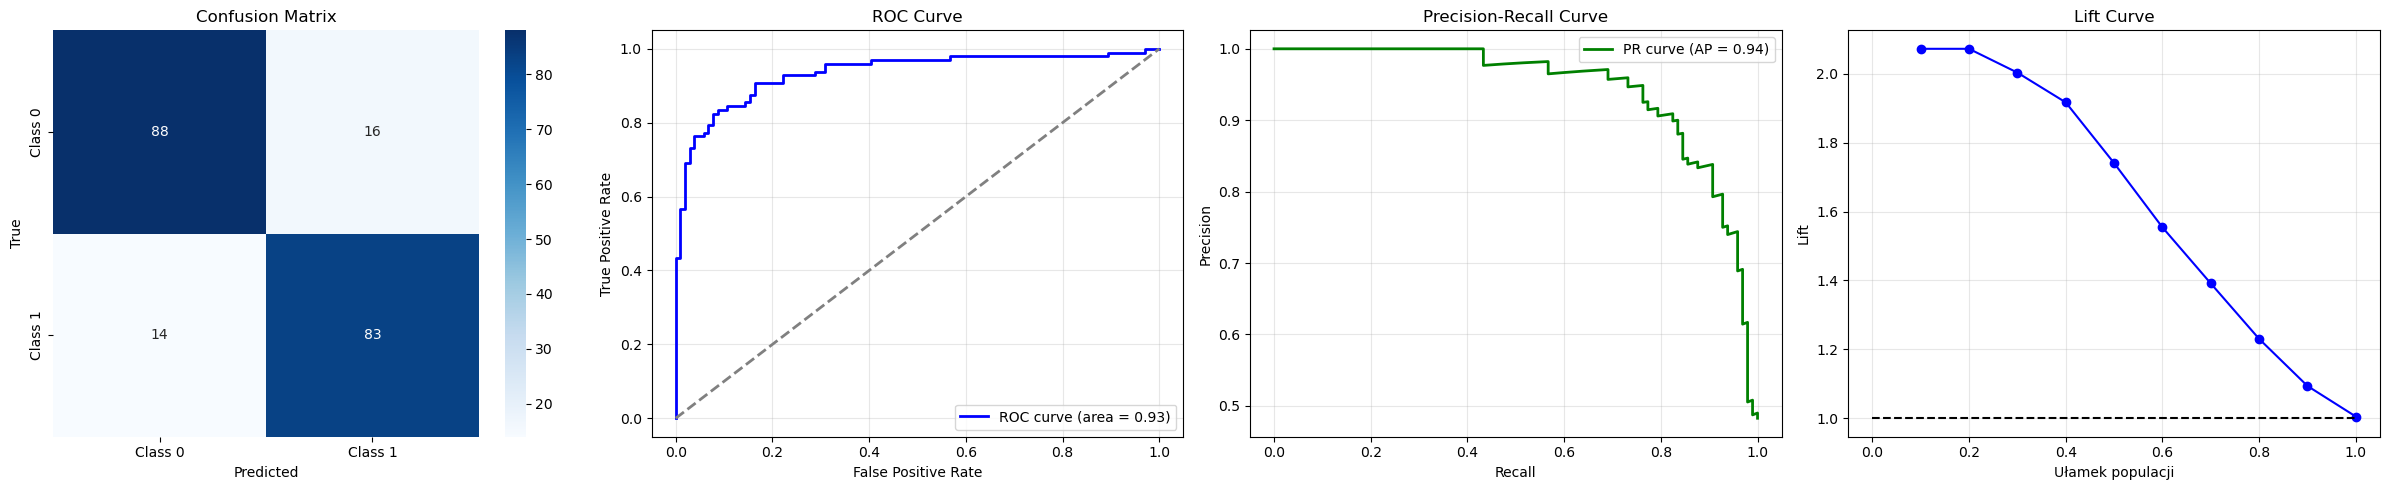

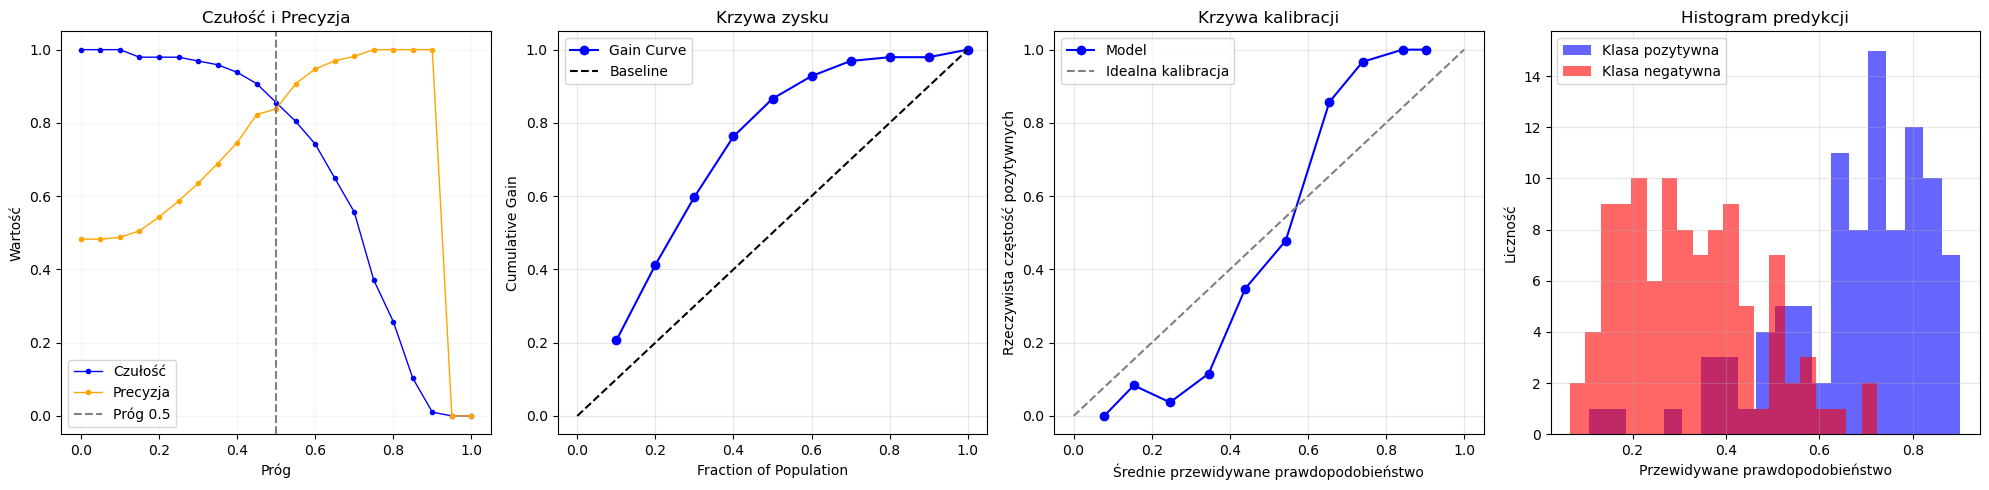

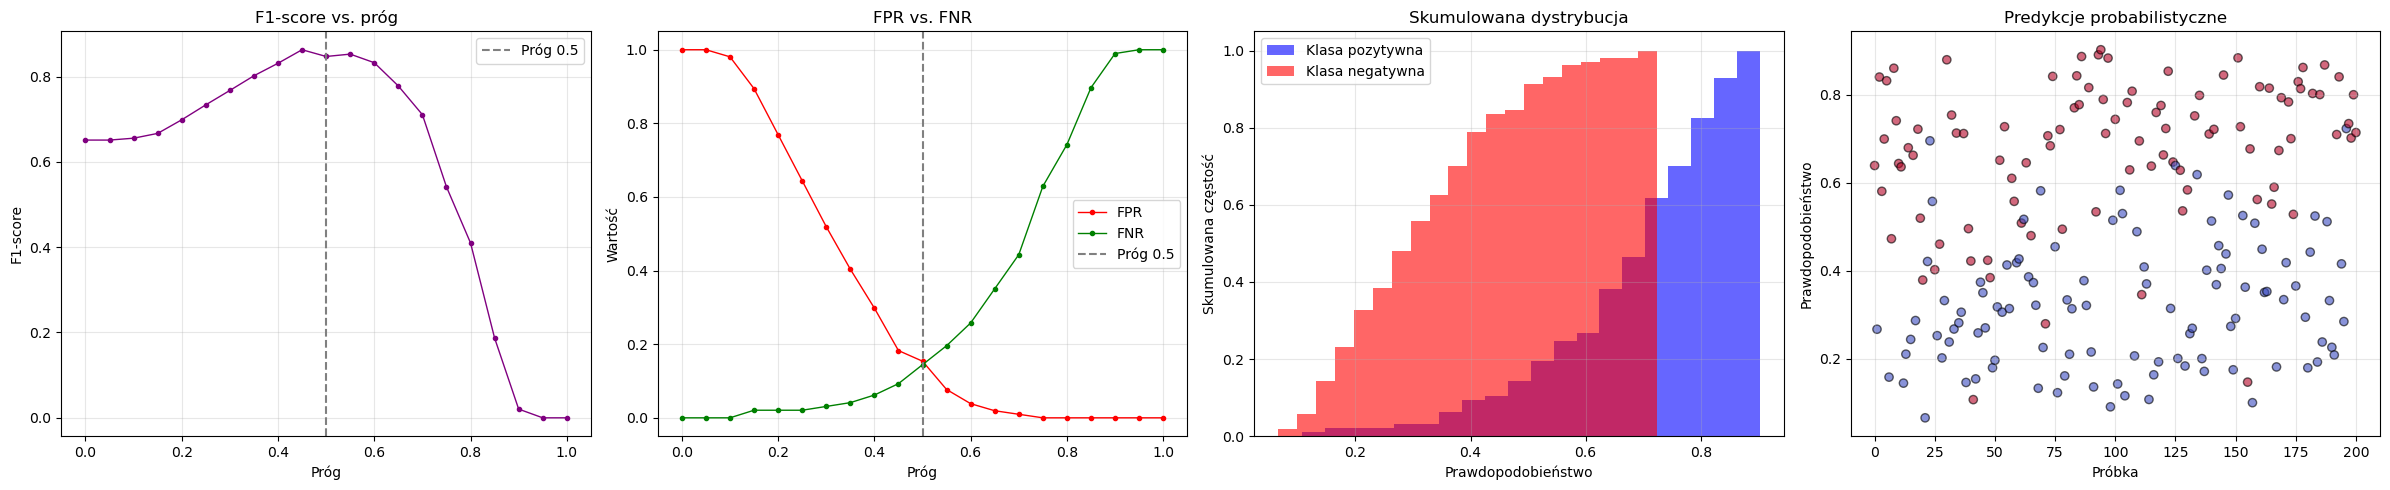

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score, 
                             confusion_matrix)


def plot_all_metrics(y_test, y_pred, y_prob, classes=['Class 0', 'Class 1'], bins=10):
    fig, axes = plt.subplots(1, 4, figsize=(24, 5))

    # Macierz konfuzji
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix')

    # Krzywa ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    axes[1].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('ROC Curve')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    average_precision = average_precision_score(y_test, y_prob)
    axes[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
    axes[2].set_xlabel('Recall')
    axes[2].set_ylabel('Precision')
    axes[2].set_title('Precision-Recall Curve')
    axes[2].legend(loc="best")
    axes[2].grid(True, alpha=0.3)

    # Krzywa Lift
    indices = np.argsort(y_prob)[::-1]
    sorted_y_true = np.array(y_test)[indices]
    population_size = len(y_test)
    bin_size = population_size // bins
    positive_rate = np.mean(y_test)
    lifts, x_points = [], []
    for i in range(bins):
        bin_end = (i + 1) * bin_size if (i + 1) * bin_size <= population_size else population_size
        bin_positive_rate = np.mean(sorted_y_true[:bin_end])
        lifts.append(bin_positive_rate / positive_rate)
        x_points.append((i + 1) / bins)
    axes[3].plot(x_points, lifts, 'b-', marker='o')
    axes[3].plot([0, 1], [1, 1], 'k--')
    axes[3].set_xlabel('Ułamek populacji')
    axes[3].set_ylabel('Lift')
    axes[3].set_title('Lift Curve')
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_all_metrics(y_test, y_pred_test, y_prob_test)



import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Listy na wyniki
sensitivities = []
precisions = []

# Definicja progów decyzyjnych
thresholds = np.arange(0, 1.01, 0.05)
for threshold in thresholds:
    y_pred_thresh = (y_prob_test >= threshold).astype(int)
    tp = ((y_test == 1) & (y_pred_thresh == 1)).sum()
    fp = ((y_test == 0) & (y_pred_thresh == 1)).sum()
    fn = ((y_test == 1) & (y_pred_thresh == 0)).sum()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    sensitivities.append(sensitivity)
    precisions.append(precision)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Wykres czułości i precyzji
axes[0].plot(thresholds, sensitivities, label='Czułość', marker='o', color='blue', linewidth=1, markersize=3)
axes[0].plot(thresholds, precisions, label='Precyzja', marker='o', color='orange', linewidth=1, markersize=3)
axes[0].axvline(x=0.5, color='gray', linestyle='--', label='Próg 0.5')
axes[0].set_title('Czułość i Precyzja')
axes[0].set_xlabel('Próg')
axes[0].set_ylabel('Wartość')
axes[0].legend()
axes[0].grid(alpha=0.1)

# Krzywa zysku
sorted_indices = np.argsort(y_prob_test)[::-1]
sorted_y_true = np.array(y_test)[sorted_indices]
population_size = len(y_test)
bin_size = population_size // 10
cumulative_gains, x_points = [], []
total_positives = np.sum(y_test)
for i in range(10):
    bin_end = (i + 1) * bin_size if (i + 1) * bin_size <= population_size else population_size
    cumulative_positives = np.sum(sorted_y_true[:bin_end])
    cumulative_gains.append(cumulative_positives / total_positives)
    x_points.append((i + 1) / 10)
axes[1].plot(x_points, cumulative_gains, 'b-', marker='o', label='Gain Curve')
axes[1].plot([0, 1], [0, 1], 'k--', label='Baseline')
axes[1].set_title('Krzywa zysku')
axes[1].set_xlabel('Fraction of Population')
axes[1].set_ylabel('Cumulative Gain')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Krzywa kalibracji
prob_true, prob_pred = calibration_curve(y_test, y_prob_test, n_bins=10)
axes[2].plot(prob_pred, prob_true, marker='o', color='blue', label='Model')
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Idealna kalibracja')
axes[2].set_title('Krzywa kalibracji')
axes[2].set_xlabel('Średnie przewidywane prawdopodobieństwo')
axes[2].set_ylabel('Rzeczywista częstość pozytywnych')
axes[2].legend()
axes[2].grid(alpha=0.3)

# Histogram prawdopodobieństw
axes[3].hist(y_prob_test[y_test == 1], bins=20, alpha=0.6, color='blue', label='Klasa pozytywna')
axes[3].hist(y_prob_test[y_test == 0], bins=20, alpha=0.6, color='red', label='Klasa negatywna')
axes[3].set_title('Histogram predykcji')
axes[3].set_xlabel('Przewidywane prawdopodobieństwo')
axes[3].set_ylabel('Liczność')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Przygotowanie danych (załóżmy, że masz już y_test i y_prob_test)
# thresholds
thresholds = np.arange(0, 1.01, 0.05)

# F1-score w zależności od progu
f1_scores = []
for threshold in thresholds:
    y_pred_thresh = (y_prob_test >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))

# FPR i FNR
fpr_values = []
fnr_values = []

for threshold in thresholds:
    y_pred_thresh = (y_prob_test >= threshold).astype(int)
    fp = ((y_test == 0) & (y_pred_thresh == 1)).sum()
    fn = ((y_test == 1) & (y_pred_thresh == 0)).sum()
    tn = ((y_test == 0) & (y_pred_thresh == 0)).sum()
    tp = ((y_test == 1) & (y_pred_thresh == 1)).sum()
    
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    fpr_values.append(fpr)
    fnr_values.append(fnr)

# Tworzenie subplots
fig, axs = plt.subplots(1, 4, figsize=(24, 5))

# Wykres F1-score
axs[0].plot(thresholds, f1_scores, marker='o', color='purple', linewidth=1, markersize=3)
axs[0].axvline(x=0.5, color='gray', linestyle='--', label='Próg 0.5')
axs[0].set_xlabel('Próg')
axs[0].set_ylabel('F1-score')
axs[0].set_title('F1-score vs. próg')
axs[0].legend()
axs[0].grid(alpha=0.3)

# Wykres FPR i FNR
axs[1].plot(thresholds, fpr_values, label='FPR', marker='o', color='red', linewidth=1, markersize=3)
axs[1].plot(thresholds, fnr_values, label='FNR', marker='o', color='green', linewidth=1, markersize=3)
axs[1].axvline(x=0.5, color='gray', linestyle='--', label='Próg 0.5')
axs[1].set_xlabel('Próg')
axs[1].set_ylabel('Wartość')
axs[1].set_title('FPR vs. FNR')
axs[1].legend()
axs[1].grid(alpha=0.3)

# Skumulowany wykres dystrybucji
axs[2].hist(y_prob_test[y_test == 1], bins=20, alpha=0.6, color='blue', label='Klasa pozytywna', cumulative=True, density=True)
axs[2].hist(y_prob_test[y_test == 0], bins=20, alpha=0.6, color='red', label='Klasa negatywna', cumulative=True, density=True)
axs[2].set_xlabel('Prawdopodobieństwo')
axs[2].set_ylabel('Skumulowana częstość')
axs[2].set_title('Skumulowana dystrybucja')
axs[2].legend()
axs[2].grid(alpha=0.3)

# Wykres punktowy prawdopodobieństw
scatter = axs[3].scatter(np.arange(len(y_test)), y_prob_test, c=y_test, cmap='coolwarm', edgecolors='k', alpha=0.6)
axs[3].set_xlabel('Próbka')
axs[3].set_ylabel('Prawdopodobieństwo')
axs[3].set_title('Predykcje probabilistyczne')
axs[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()



## Analiza Wydajności Modelu Klasyfikacji Binarnej

Wizualizacje różnych aspektów wydajności modelu klasyfikacji binarnej za pomocą wykresów.

1.  **Macierz Konfuzji (Confusion Matrix):**
    * Wizualizuje liczbę poprawnych i błędnych przewidywań modelu.
    * Ułatwia zrozumienie, gdzie model popełnia błędy.
2.  **Krzywa ROC (Receiver Operating Characteristic):**
    * Pokazuje zależność między czułością a specyficznością dla różnych progów.
    * AUC (pole pod krzywą) mierzy zdolność modelu do rozróżniania klas.
3.  **Krzywa Precision-Recall (Precision-Recall Curve):**
    * Pokazuje zależność między precyzją a pokryciem dla różnych progów.
    * AP (średnia precyzja) podsumowuje wydajność modelu.
4.  **Krzywa Lift (Lift Curve):**
    * Pokazuje efektywność modelu w identyfikacji pozytywnych przypadków.
    * Mierzy, ile razy model poprawia identyfikację w "binach" populacji.
5.  **Wykres Czułości i Precyzji (Sensitivity and Precision):**
    * Pokazuje, jak zmieniają się czułość i precyzja w zależności od progu.
    * Pomaga w wyborze optymalnego progu.
6.  **Krzywa Zysku (Gain Curve):**
    * Pokazuje skumulowany zysk, czyli odsetek poprawnie zidentyfikowanych pozytywnych przypadków.
    * Ocenia efektywność modelu w kolejnych segmentach populacji.
7.  **Krzywa Kalibracji (Calibration Curve):**
    * Porównuje przewidywane prawdopodobieństwa z rzeczywistymi częstościami.
    * Ocenia, czy model jest dobrze skalibrowany.
8.  **Histogram Prawdopodobieństw (Probability Histogram):**
    * Pokazuje rozkład przewidywanych prawdopodobieństw dla klas.
    * Ocenia, jak model rozdziela klasy.
9.  **Wykres F1-score vs. Próg:**
    * Pokazuje, jak zmienia się F1-score w zależności od progu decyzyjnego.
    * F1-score jest średnią harmoniczną precyzji i pokrycia, co pozwala na ocenę zrównoważonej wydajności modelu.
    * Pomaga w wyborze optymalnego progu, który maksymalizuje F1-score.

10.  **Wykres FPR vs. FNR:**
    * Pokazuje, jak zmieniają się False Positive Rate (FPR) i False Negative Rate (FNR) w zależności od progu decyzyjnego.
    * FPR mierzy odsetek błędnie zaklasyfikowanych negatywnych przypadków jako pozytywne.
    * FNR mierzy odsetek błędnie zaklasyfikowanych pozytywnych przypadków jako negatywne.
    * Pomaga w wyborze progu, który minimalizuje błędy obu typów, w zależności od potrzeb aplikacji.

11.  **Skumulowana Dystrybucja Prawdopodobieństw:**
    * Pokazuje skumulowaną dystrybucję przewidywanych prawdopodobieństw dla klas pozytywnej i negatywnej.
    * Pozwala ocenić, jak dobrze model rozdziela klasy i jak rozkładają się prawdopodobieństwa.
    * Ułatwia zrozumienie, jak zmienia się odsetek przypadków w zależności od progu.
    
12.  **Wykres Punktowy Prawdopodobieństw:**
    * Pokazuje rozkład przewidywanych prawdopodobieństw dla każdej próbki w zbiorze testowym.
    * Kolor punktów reprezentuje rzeczywistą klasę (pozytywną lub negatywną).
    * Pozwala na wizualną ocenę, jak dobrze model rozdziela klasy i jakie są przewidywane prawdopodobieństwa dla poszczególnych próbek.

> Wykresy te umożliwię wszechstronną ocenę modelu klasyfikacji binarnej, uwzględniając różne aspekty jego wydajności. Wykresy i metryki pozwalają na identyfikację mocnych i słabych stron modelu oraz na dostosowanie jego parametrów w celu optymalizacji wyników.